In [1]:
%%capture
!pip install --no-cache-dir -U scikit-learn==1.4.1.post1 imbalanced-learn==0.11.0


In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='threadpoolctl')


In [3]:
import time
from collections import Counter
from itertools import product
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib_venn import venn3
from tqdm import tqdm


from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor,
    RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
)
from sklearn.svm import SVC
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.tree import plot_tree
from scipy.stats import randint

from sklearn.model_selection import (
    train_test_split, KFold, cross_val_score,
    RandomizedSearchCV, GridSearchCV
)

from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.base import clone
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, silhouette_score, davies_bouldin_score
)

from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostRegressor, CatBoostClassifier

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline


# Parte 1: Regresión

## Exploración y Preprocesamiento

En primer lugar importamos todas las librerias necesarias para este trabajo

A continuación almacenamos el csv en un dataframe:

In [4]:
df= pd.read_csv("/kaggle/input/performance/clases_performance.csv")

Una vez recopilados los datos, es importante obtener una visión general del tipo de datos presentes en el dataframe y de los valores que contienen tanto las variables categóricas como las numéricas.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6607 non-null   int64 
 1   Attendance                  6607 non-null   int64 
 2   Parental_Involvement        6607 non-null   object
 3   Access_to_Resources         6607 non-null   object
 4   Extracurricular_Activities  6607 non-null   object
 5   Sleep_Hours                 6607 non-null   int64 
 6   Previous_Scores             6607 non-null   int64 
 7   Motivation_Level            6607 non-null   object
 8   Internet_Access             6607 non-null   object
 9   Tutoring_Sessions           6607 non-null   int64 
 10  Family_Income               6607 non-null   object
 11  Teacher_Quality             6529 non-null   object
 12  School_Type                 6607 non-null   object
 13  Peer_Influence              6607 non-null   obje

### Variables numéricas

In [6]:
df.describe()

Hours_Studied   Attendance  Sleep_Hours  Previous_Scores  \
count    6607.000000  6607.000000   6607.00000      6607.000000   
mean       19.975329    79.977448      7.02906        75.070531   
std         5.990594    11.547475      1.46812        14.399784   
min         1.000000    60.000000      4.00000        50.000000   
25%        16.000000    70.000000      6.00000        63.000000   
50%        20.000000    80.000000      7.00000        75.000000   
75%        24.000000    90.000000      8.00000        88.000000   
max        44.000000   100.000000     10.00000       100.000000   

       Tutoring_Sessions  Physical_Activity   Exam_Score  
count        6607.000000        6607.000000  6607.000000  
mean            1.493719           2.967610    67.235659  
std             1.230570           1.031231     3.890456  
min             0.000000           0.000000    55.000000  
25%             1.000000           2.000000    65.000000  
50%             1.000000           3.000000    67.000000  
75%             2.000000           4.000000    69.000000  
max             8.000000           6.000000   101.000000

En general, las variables numéricas en el dataset muestran una variedad de comportamientos y rangos que pueden influir en el rendimiento estudiantil. Hours_Studied y Attendance tienen valores relativamente altos en promedio, lo que sugiere que la mayoría de los estudiantes dedican una cantidad considerable de tiempo al estudio y mantienen una buena asistencia. 

Sleep_Hours y Previous_Scores presentan valores medios dentro de lo esperado, aunque Previous_Scores tiene una mayor dispersión, lo que podría indicar variaciones en el rendimiento previo. Tutoring_Sessions y Physical_Activity muestran una tendencia hacia valores bajos, con pocos estudiantes dedicando muchas horas a estas actividades. Exam_Score, por su parte, tiene una media de 67, con valores concentrados entre 65 y 69. 

En cuanto a valores anómalos, se observa un valor en Exam_Score, donde un alumno tiene una puntuación de 101. Esto parece un error, ya que suponemos que los exámenes están calificados sobre 100 puntos. Dado que este valor pertenece a un solo estudiante, se ha decidido descartarlo para evitar que afecte el análisis.

In [7]:
# Eliminamos el elemento con la nota superior a 100 puntos.
df.drop(df[df["Exam_Score"]==101].index, inplace=True)

### Variables categóricas:

In [8]:
df.describe(include=[object])

Parental_Involvement Access_to_Resources Extracurricular_Activities  \
count                  6606                6606                       6606   
unique                    3                   3                          2   
top                  Medium              Medium                        Yes   
freq                   3362                3318                       3937   

       Motivation_Level Internet_Access Family_Income Teacher_Quality  \
count              6606            6606          6606            6528   
unique                3               2             3               3   
top              Medium             Yes           Low          Medium   
freq               3351            6108          2672            3925   

       School_Type Peer_Influence Learning_Disabilities  \
count         6606           6606                  6606   
unique           2              3                     2   
top         Public       Positive                    No   
freq          4597           2637                  5911   

       Parental_Education_Level Distance_from_Home Gender  
count                      6516               6539   6606  
unique                        3                  3      2  
top                 High School               Near   Male  
freq                       3222               3884   3814

Las variables categóricas tienen entre 2 y 3 categorías, con valores predominantes como "Medium" o "Yes" en variables como Parental_Involvement y Motivation_Level. Algunas columnas, como Teacher_Quality, Parental_Education_Level y Distance_from_Home, presentan valores nulos, lo que requerirá un tratamiento adicional para gestionar los datos faltantes.

In [9]:
df_na_sum = df.isna().sum()

# Filtrar las columnas que tienen valores nulos
df_na = df_na_sum[df_na_sum != 0]

print("Variables que presentan valores nulos: ")
for feature, missing_count in df_na.items():
    percentage_missing = missing_count * 100 / df.shape[0]
    print(f"{feature}: {missing_count} nulos, ({percentage_missing:.2f}%)")


Variables que presentan valores nulos: 
Teacher_Quality: 78 nulos, (1.18%)
Parental_Education_Level: 90 nulos, (1.36%)
Distance_from_Home: 67 nulos, (1.01%)


### Lenado de valores nulos

Una vez identificados los porcentajes de valores faltantes en cada columna del dataset, el siguiente paso es abordar el tratamiento de estos valores, considerando el tipo de datos faltantes en cada caso. Utilizando diagramas de Venn, podemos analizar si los valores vacíos en cada variable aparecen de forma independiente o si están presentes simultáneamente en varias categorías.

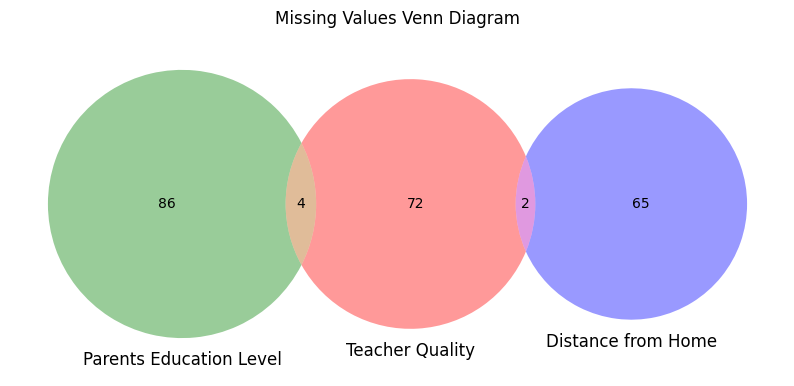

In [10]:
teacher_nan = set(df[df['Teacher_Quality'].isna()].index)
parents_nan = set(df[df['Parental_Education_Level'].isna()].index)
distance_nan = set(df[df['Distance_from_Home'].isna()].index)

plt.figure(figsize=(10, 6))
venn = venn3([teacher_nan, parents_nan, distance_nan], 
             set_labels=('Teacher Quality', 'Parents Education Level', 'Distance from Home'))
plt.title("Missing Values Venn Diagram")
plt.show()


Dado que hay pocas intersecciones entre las categorías con valores nulos, eliminar esos registros resultaría en una pérdida considerable de información en otras columnas. Si las intersecciones fueran mayores, podríamos optar por eliminarlos debido a la limitada información relevante en dichos casos. Por ello, se ha decidido imputar los valores nulos reemplazándolos con el valor más frecuente en cada columna, dado que se trata de variables categóricas.

Para evaluar el impacto de este método, graficaremos la proporción de las distintas categorías dentro de las variables con valores faltantes antes y después del llenado.

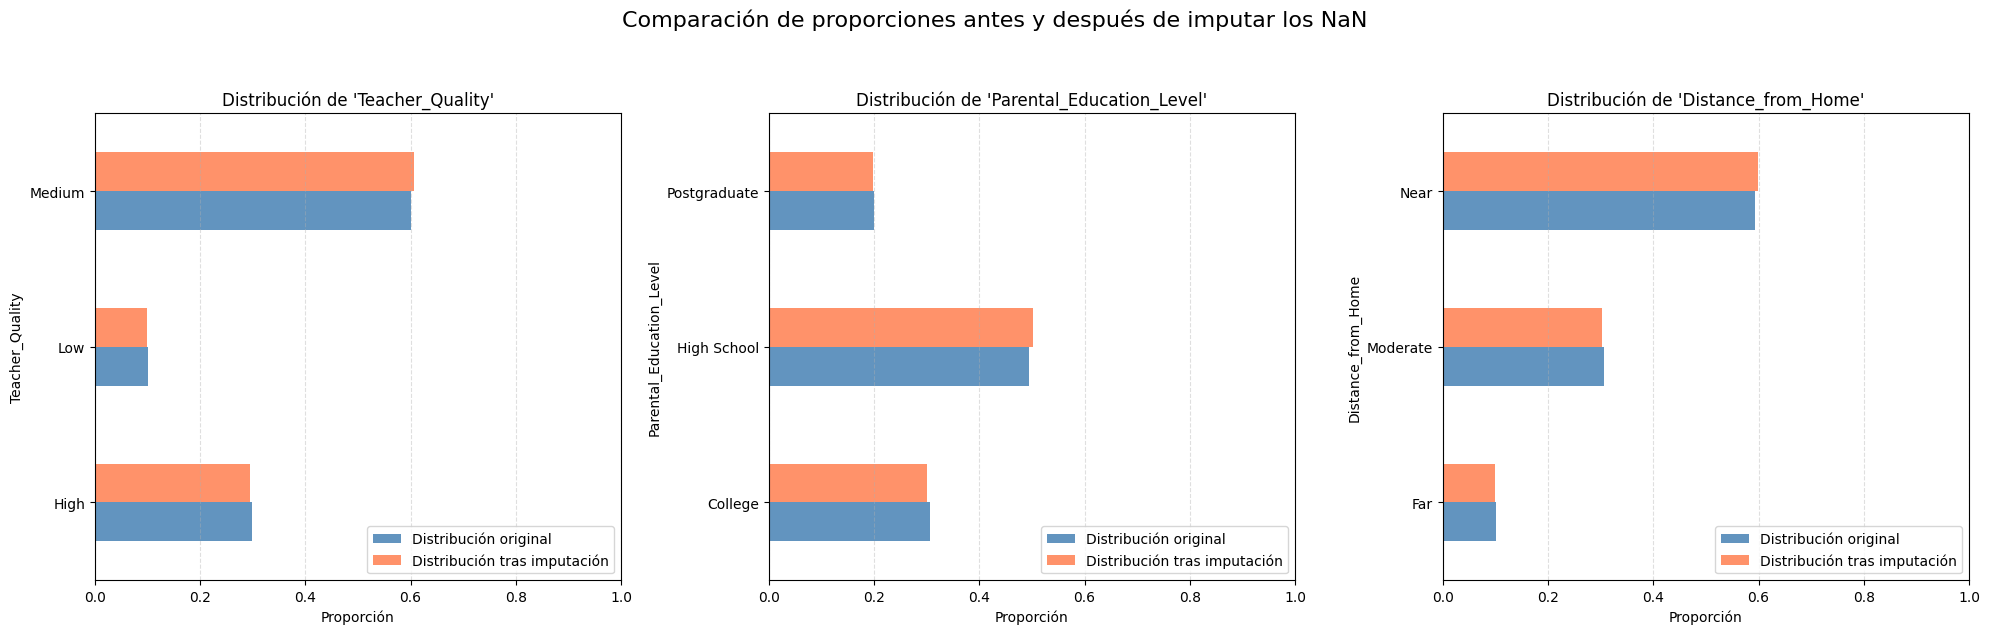

In [11]:


fig, axes = plt.subplots(1, 3, figsize=(20, 6))
na_features = ['Teacher_Quality', 'Parental_Education_Level', 'Distance_from_Home']
colors = ['steelblue', 'coral']  

for i, feature in enumerate(na_features):
    # Proporciones antes y después de la imputación
    original_counts = df[feature].value_counts(normalize=True).sort_index()
    filled_temp = df[feature].fillna(df[feature].mode()[0])
    filled_counts = filled_temp.value_counts(normalize=True).sort_index()
    
    # Unir proporciones en un DataFrame
    data = pd.DataFrame({
        'Distribución original': original_counts,
        'Distribución tras imputación': filled_counts
    }).fillna(0)
    
    data.plot(kind='barh', ax=axes[i], color=colors, alpha=0.85)
    axes[i].set_title(f"Distribución de '{feature}'")
    axes[i].set_xlabel("Proporción")
    axes[i].set_xlim(0, 1)
    axes[i].legend(loc='lower right')
    axes[i].grid(axis='x', linestyle='--', alpha=0.4)

fig.suptitle("Comparación de proporciones antes y después de imputar los NaN", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()


No se observa una diferencia significativa en las proporciones entre las distintas categorías, lo que indica que este método es adecuado para tratar los valores nulos en este caso. Alternativamente, podríamos realizar una prueba de chi-cuadrado para comparar las frecuencias antes y después del llenado y confirmar estadísticamente la estabilidad de la distribución.

Si el método de llenado hubiera afectado notablemente la distribución, podríamos considerar otras opciones, como rellenar los valores nulos con valores aleatorios, o incluso eliminarlos y evaluar el impacto en el análisis antes y después de la eliminación.

In [12]:
# Creamos un nuevo dataframe ya sin valores nulos
na_features = ['Teacher_Quality', 'Parental_Education_Level', 'Distance_from_Home']

filled_df = df.copy()

for feature in na_features:
    mode_value = filled_df[feature].mode()[0]  
    filled_df[feature] = filled_df[feature].fillna(mode_value)


missing_before = df[na_features].isna().sum()
missing_after = filled_df[na_features].isna().sum()

missing_comparison = pd.DataFrame({
    "Missing Before": missing_before,
    "Missing After": missing_after
})

print(missing_comparison)



                          Missing Before  Missing After
Teacher_Quality                       78              0
Parental_Education_Level              90              0
Distance_from_Home                    67              0


### Visualización

Antes de aplicar modelos de regresión, es conveniente realizar una exploración visual básica del dataset. Esto permite observar la distribución de la variable objetivo (Exam_Score) y detectar posibles relaciones entre las variables numéricas que podrían influir en el rendimiento académico.



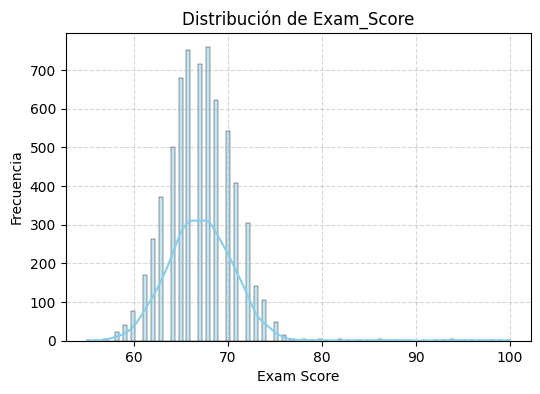

In [13]:

# Variables numéricas
numerical_vars = df.select_dtypes(include='number').columns.tolist()

# Distribución de la variable objetivo
plt.figure(figsize=(6, 4))
sns.histplot(df["Exam_Score"], kde=True, color='skyblue', edgecolor='black')
plt.title("Distribución de Exam_Score")
plt.xlabel("Exam Score")
plt.ylabel("Frecuencia")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()



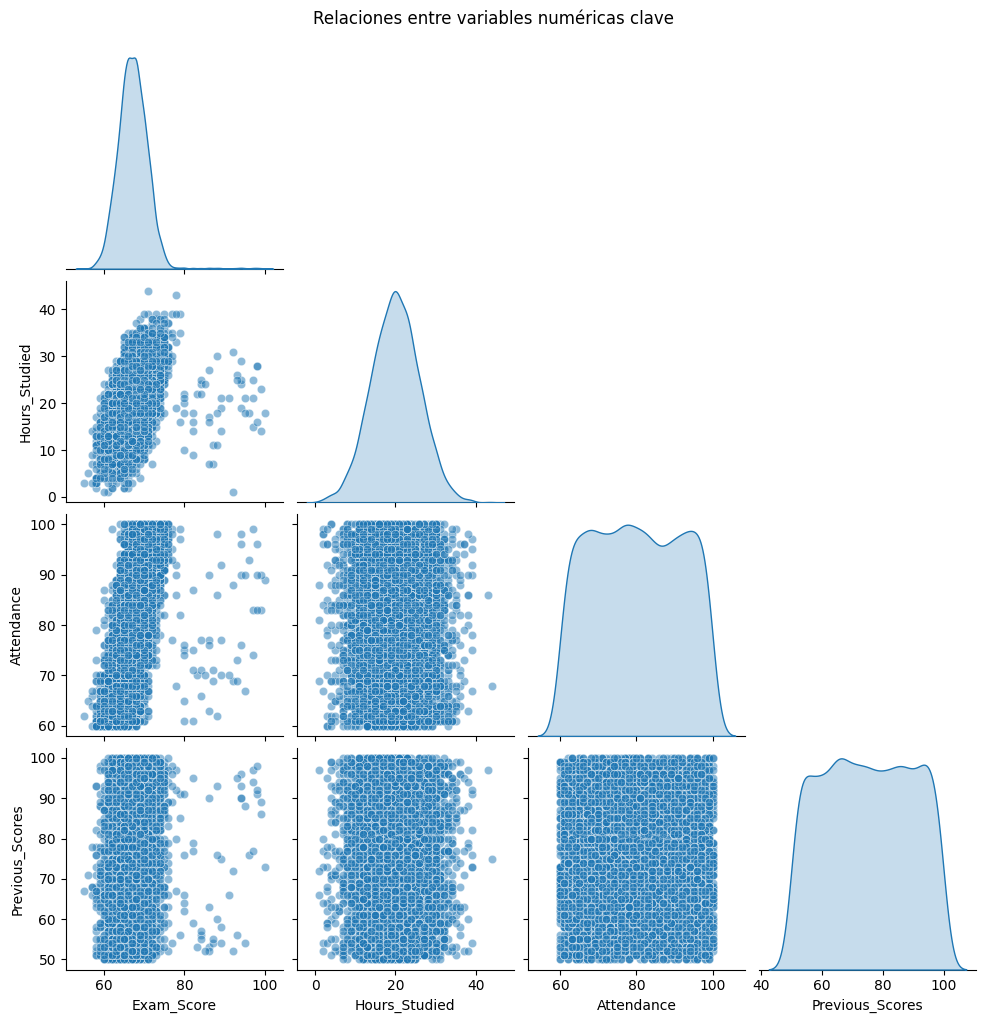

In [14]:
# Pairplot de variables relevantes
relevant_numeric = ['Exam_Score', 'Hours_Studied', 'Attendance', 'Previous_Scores']
sns.pairplot(df[relevant_numeric], corner=True, diag_kind='kde', plot_kws={'alpha': 0.5})
plt.suptitle("Relaciones entre variables numéricas clave", y=1.02)
plt.show()


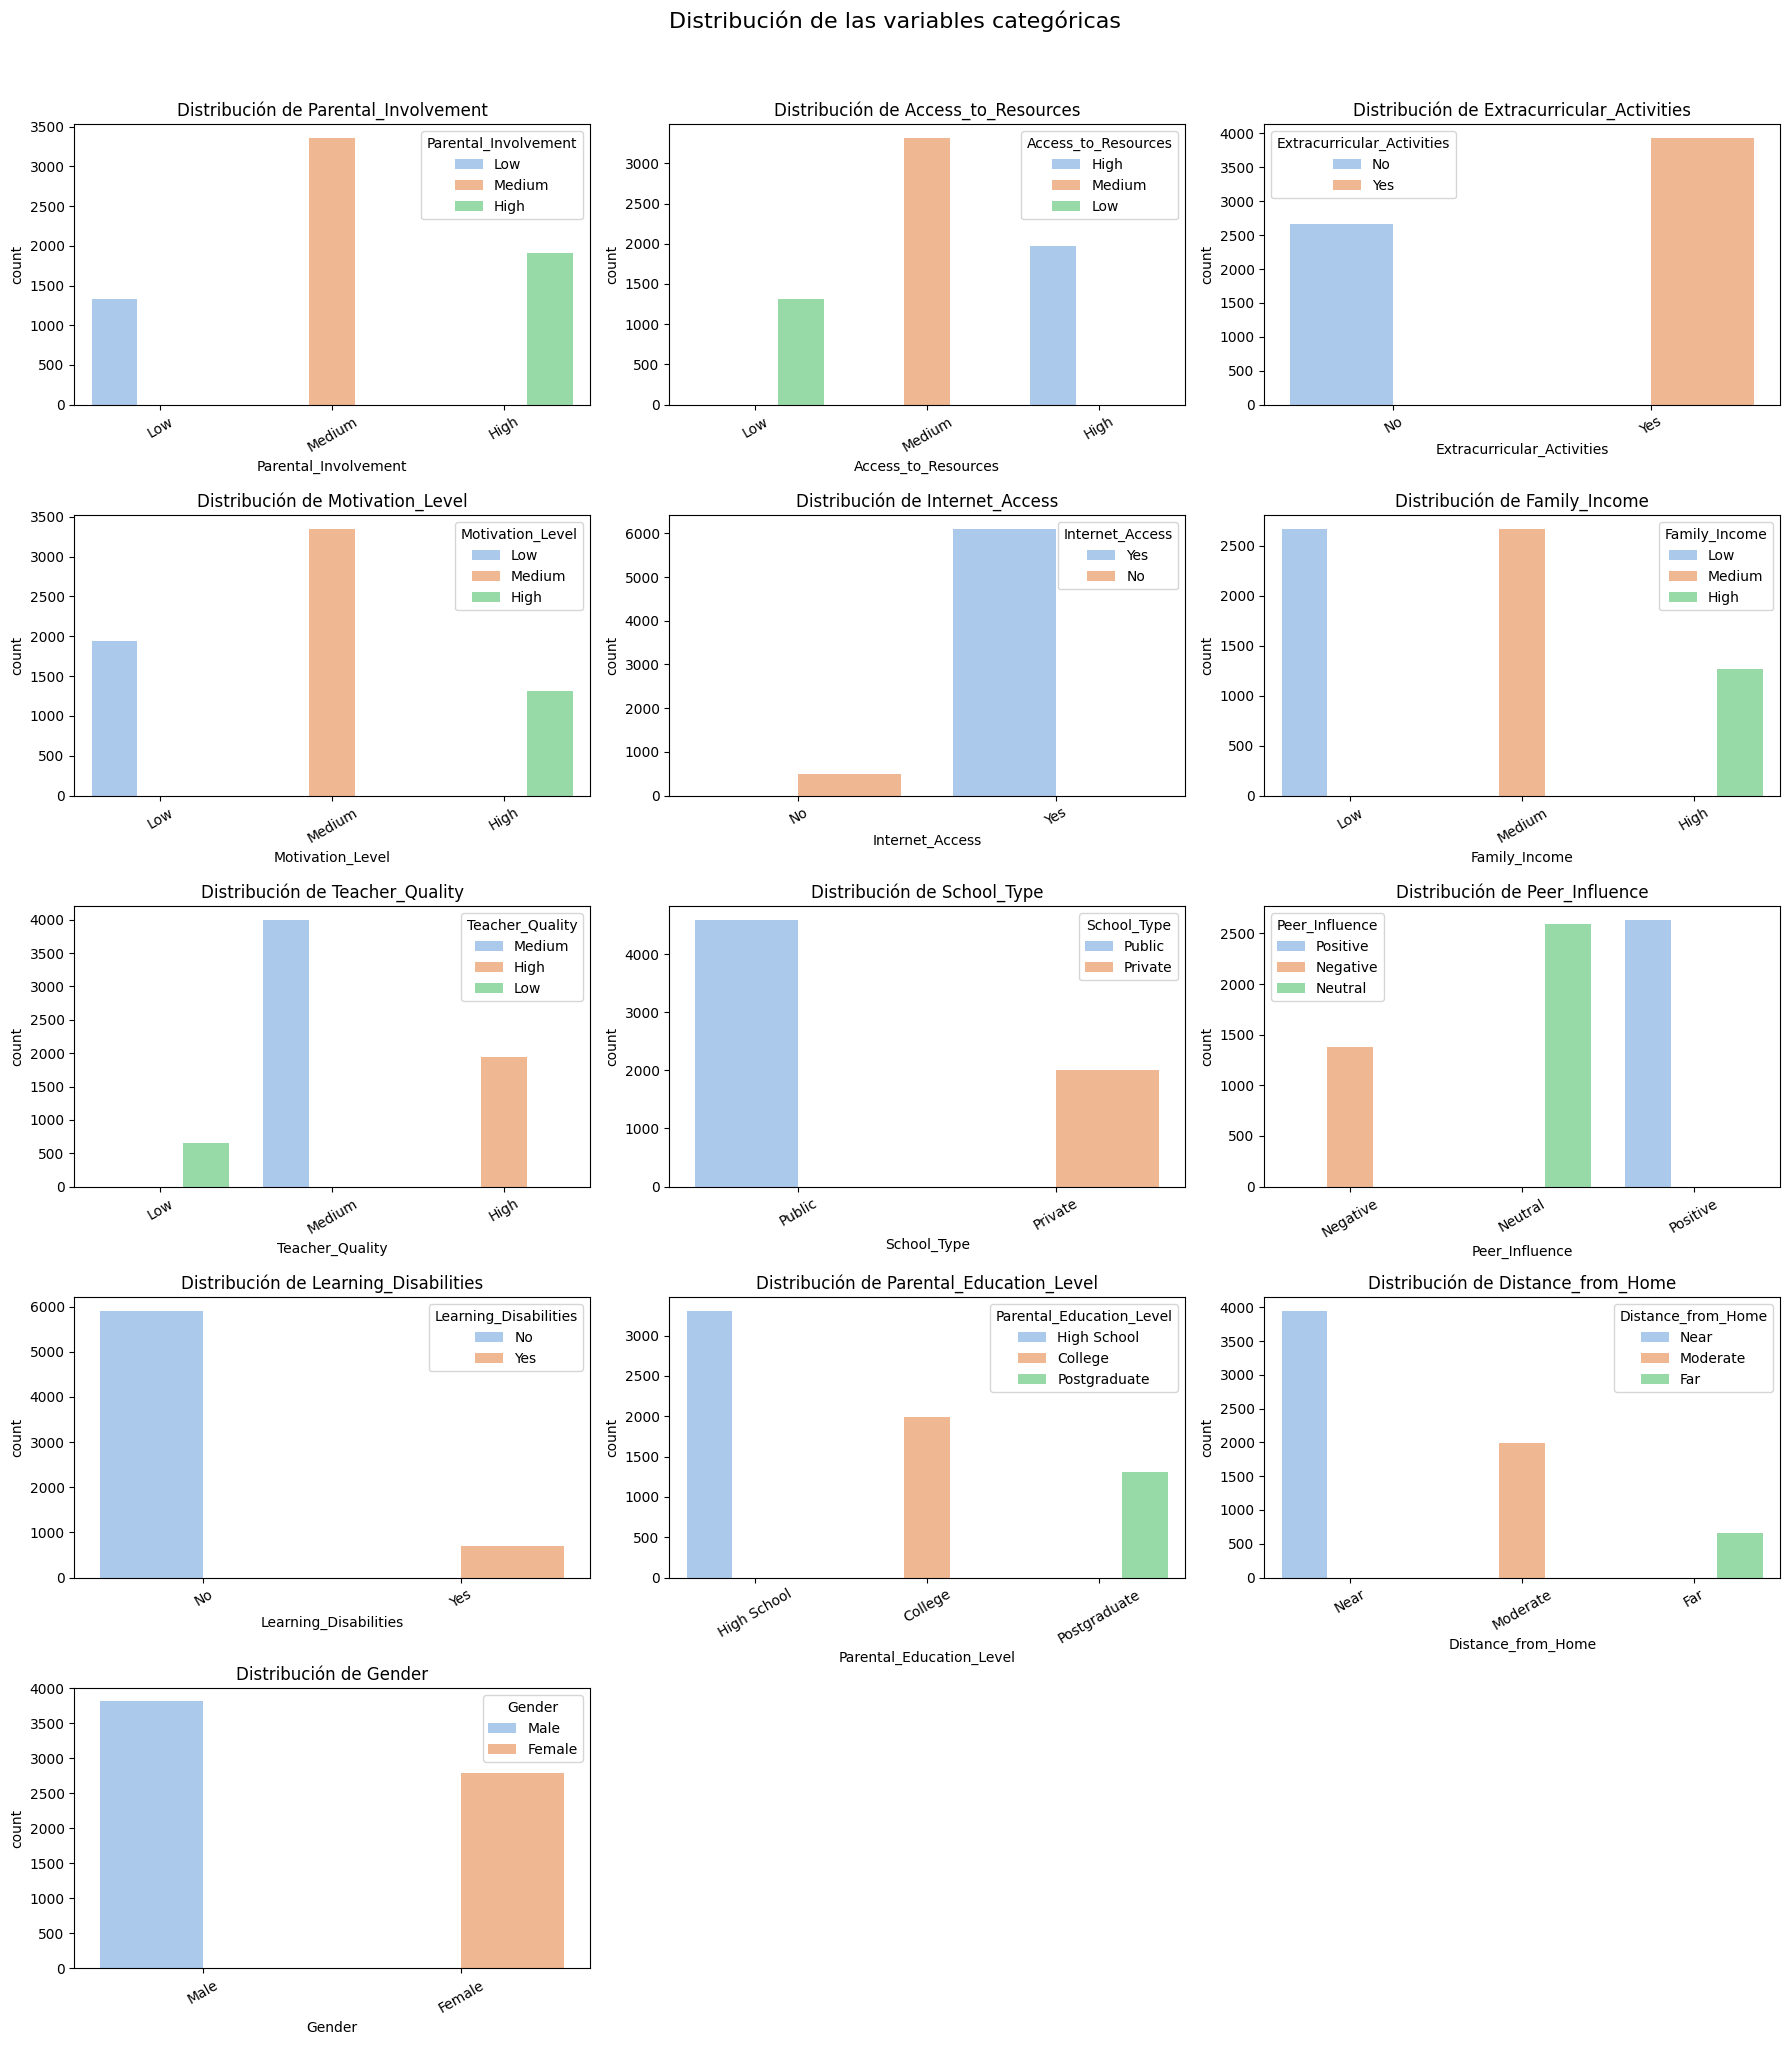

In [15]:

# Detectamos automáticamente las variables categóricas
categorical_vars = filled_df.select_dtypes(include='object').columns.tolist()

# Diccionario con orden personalizado para algunas variables
custom_orders = {
    'Parental_Involvement': ['Low', 'Medium', 'High'],
    'Family_Income': ['Low', 'Medium', 'High'],
    'Motivation_Level': ['Low', 'Medium', 'High'],
    'Teacher_Quality': ['Low', 'Medium', 'High'],
    'Distance_from_Home': ['Near', 'Moderate', 'Far'],
    'Gender': ['Male', 'Female'],
    'Internet_Access': ['No', 'Yes'],
    'Learning_Disabilities': ['No', 'Yes'],
    'School_Type': ['Public', 'Private'],
    'Extracurricular_Activities': ['No', 'Yes'],
    'Access_to_Resources': ['Low', 'Medium', 'High'],
    'Peer_Influence': ['Negative', 'Neutral', 'Positive'],
    'Parental_Education_Level': ['High School', 'College', 'Postgraduate']
}

n_cols = 3
n_rows = (len(categorical_vars) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.flatten()

# Plot para cada variable categórica
for i, var in enumerate(categorical_vars):
    order = custom_orders.get(var, filled_df[var].value_counts().index)
    sns.countplot(data=filled_df, x=var, ax=axes[i], palette='pastel',hue=var, order=order)
    axes[i].set_title(f'Distribución de {var}', fontsize=12)
    axes[i].tick_params(axis='x', rotation=30)

# Eliminar subgráficas vacías
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Distribución de las variables categóricas", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


A partir de la visualización de las variables categóricas, se observa que muchas de ellas presentan una distribución desequilibrada entre clases. Por ejemplo, variables como `Internet_Access`, `Learning_Disabilities`, y `School_Type` muestran una clara desproporción, con una mayoría significativa de estudiantes con acceso a internet, sin discapacidades de aprendizaje, y pertenecientes a escuelas públicas. Otras variables como `Motivation_Level`, `Teacher_Quality` o `Family_Income` presentan una distribución más equilibrada, aunque con predominio de la categoría "Medium". En el caso de `Parental_Involvement` y `Access_to_Resources`, también se detecta una concentración en niveles medios. Este análisis preliminar permite identificar qué variables podrían tener menor capacidad explicativa por su falta de variabilidad, lo cual será importante a la hora de construir modelos predictivos.


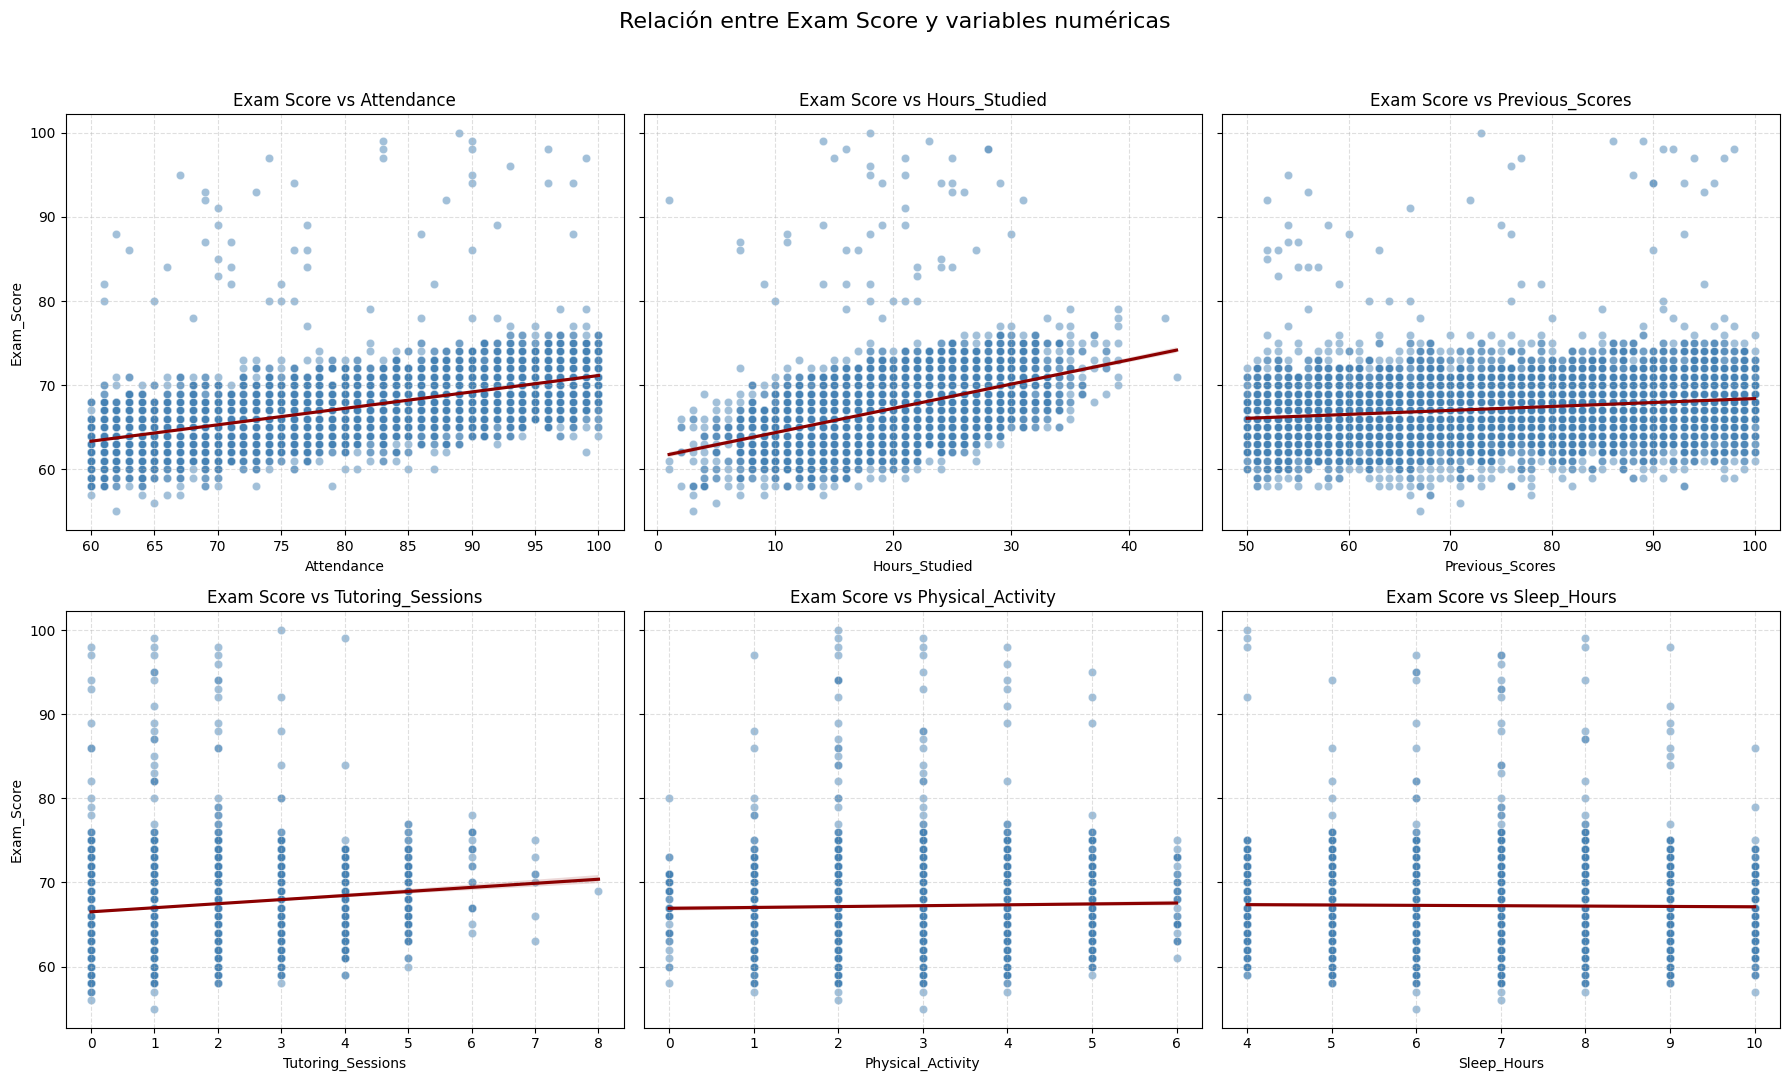

In [16]:

# Variables a comparar con Exam_Score
variables = [
    'Attendance', 'Hours_Studied', 'Previous_Scores',
    'Tutoring_Sessions', 'Physical_Activity', 'Sleep_Hours'
]

n_cols = 3
n_rows = (len(numerical_vars) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows), sharey=True)
axes = axes.flatten()

for i, var in enumerate(variables):
    sns.scatterplot(data=filled_df, x=var, y='Exam_Score', ax=axes[i], alpha=0.5, color='steelblue')
    sns.regplot(data=filled_df, x=var, y='Exam_Score', ax=axes[i], scatter=False, color='darkred')
    axes[i].set_title(f'Exam Score vs {var}')
    axes[i].grid(True, linestyle='--', alpha=0.4)

# Eliminar subgráficas vacías (si sobran)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Relación entre Exam Score y variables numéricas", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


In [17]:
correlation = filled_df.corr(numeric_only=True)['Exam_Score'].drop('Exam_Score')

def categorize_corr(val):
    abs_val = abs(val)
    if abs_val >= 0.7:
        return 'Fuerte'
    elif abs_val >= 0.4:
        return 'Moderada'
    elif abs_val >= 0.15:
        return 'Débil'
    else:
        return 'Muy débil o nula'

correlation_df = correlation.to_frame(name='Correlación')
correlation_df['Nivel'] = correlation_df['Correlación'].apply(categorize_corr)
correlation_df = correlation_df.sort_values(by='Correlación', ascending=False)

correlation_df

Correlación             Nivel
Attendance            0.582458          Moderada
Hours_Studied         0.446514          Moderada
Previous_Scores       0.174461             Débil
Tutoring_Sessions     0.153754             Débil
Physical_Activity     0.027943  Muy débil o nula
Sleep_Hours          -0.016194  Muy débil o nula

<Axes: >

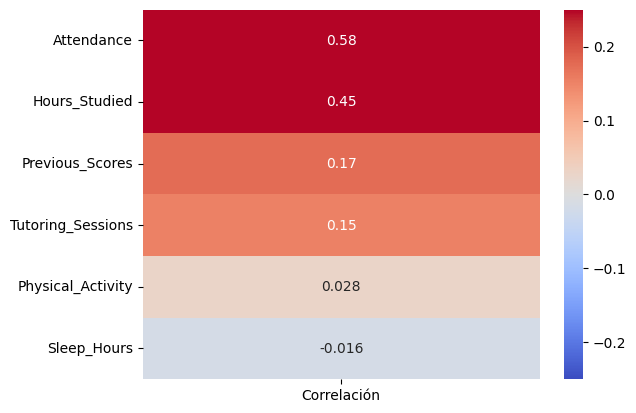

In [18]:
sns.heatmap(correlation_df[['Correlación']],cmap='coolwarm', annot=True, vmax=0.25, vmin=-0.25)

En los gráficos de dispersión se observa que tanto la asistencia (Attendance) como las horas de estudio (Hours_Studied) presentan una relación claramente positiva con el rendimiento académico, reforzando su papel como factores clave. En cambio, otras variables como Previous_Scores, Tutoring_Sessions, Physical_Activity y Sleep_Hours muestran distribuciones más dispersas, sin una tendencia lineal evidente, lo que sugiere una influencia más limitada o indirecta sobre el Exam_Score.

Aunque el análisis de correlación lineal muestra una relación muy débil entre Sleep_Hours y Exam_Score, esta conclusión resulta contraintuitiva, ya que se esperaría que el descanso tenga cierto impacto en el rendimiento académico. Por ello, se ha optado por aplicar un proceso de binning, agrupando a los estudiantes en tres categorías según sus horas de sueño (<6h, 6–7h y >7h), con el fin de visualizar posibles diferencias mediante boxplots. Esta transformación permite detectar relaciones no lineales que podrían no captarse con una simple correlación.

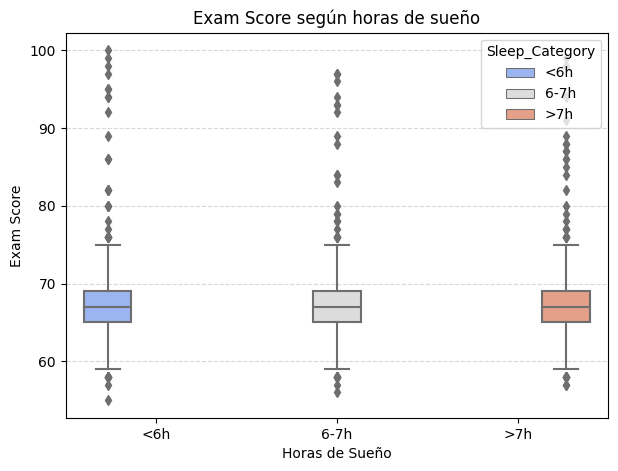

In [19]:

# Creamos bins personalizados
bins = [0, 6, 7, 10]
labels = ['<6h', '6-7h', '>7h']
filled_df['Sleep_Category'] = pd.cut(filled_df['Sleep_Hours'], bins=bins, labels=labels, include_lowest=True)

plt.figure(figsize=(7, 5))
sns.boxplot(data=filled_df, x='Sleep_Category', y='Exam_Score',hue="Sleep_Category", palette='coolwarm')
plt.title("Exam Score según horas de sueño")
plt.xlabel("Horas de Sueño")
plt.ylabel("Exam Score")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


In [20]:
filled_df["Sleep_Category"].value_counts()

Sleep_Category
>7h     2486
<6h     2379
6-7h    1741
Name: count, dtype: int64

A nivel visual, los boxplots no muestran diferencias claras en las medianas ni en la dispersión del Exam_Score entre los distintos grupos de horas de sueño. Esto sugiere que, al menos superficialmente, el descanso nocturno no presenta una relación evidente con el rendimiento académico.

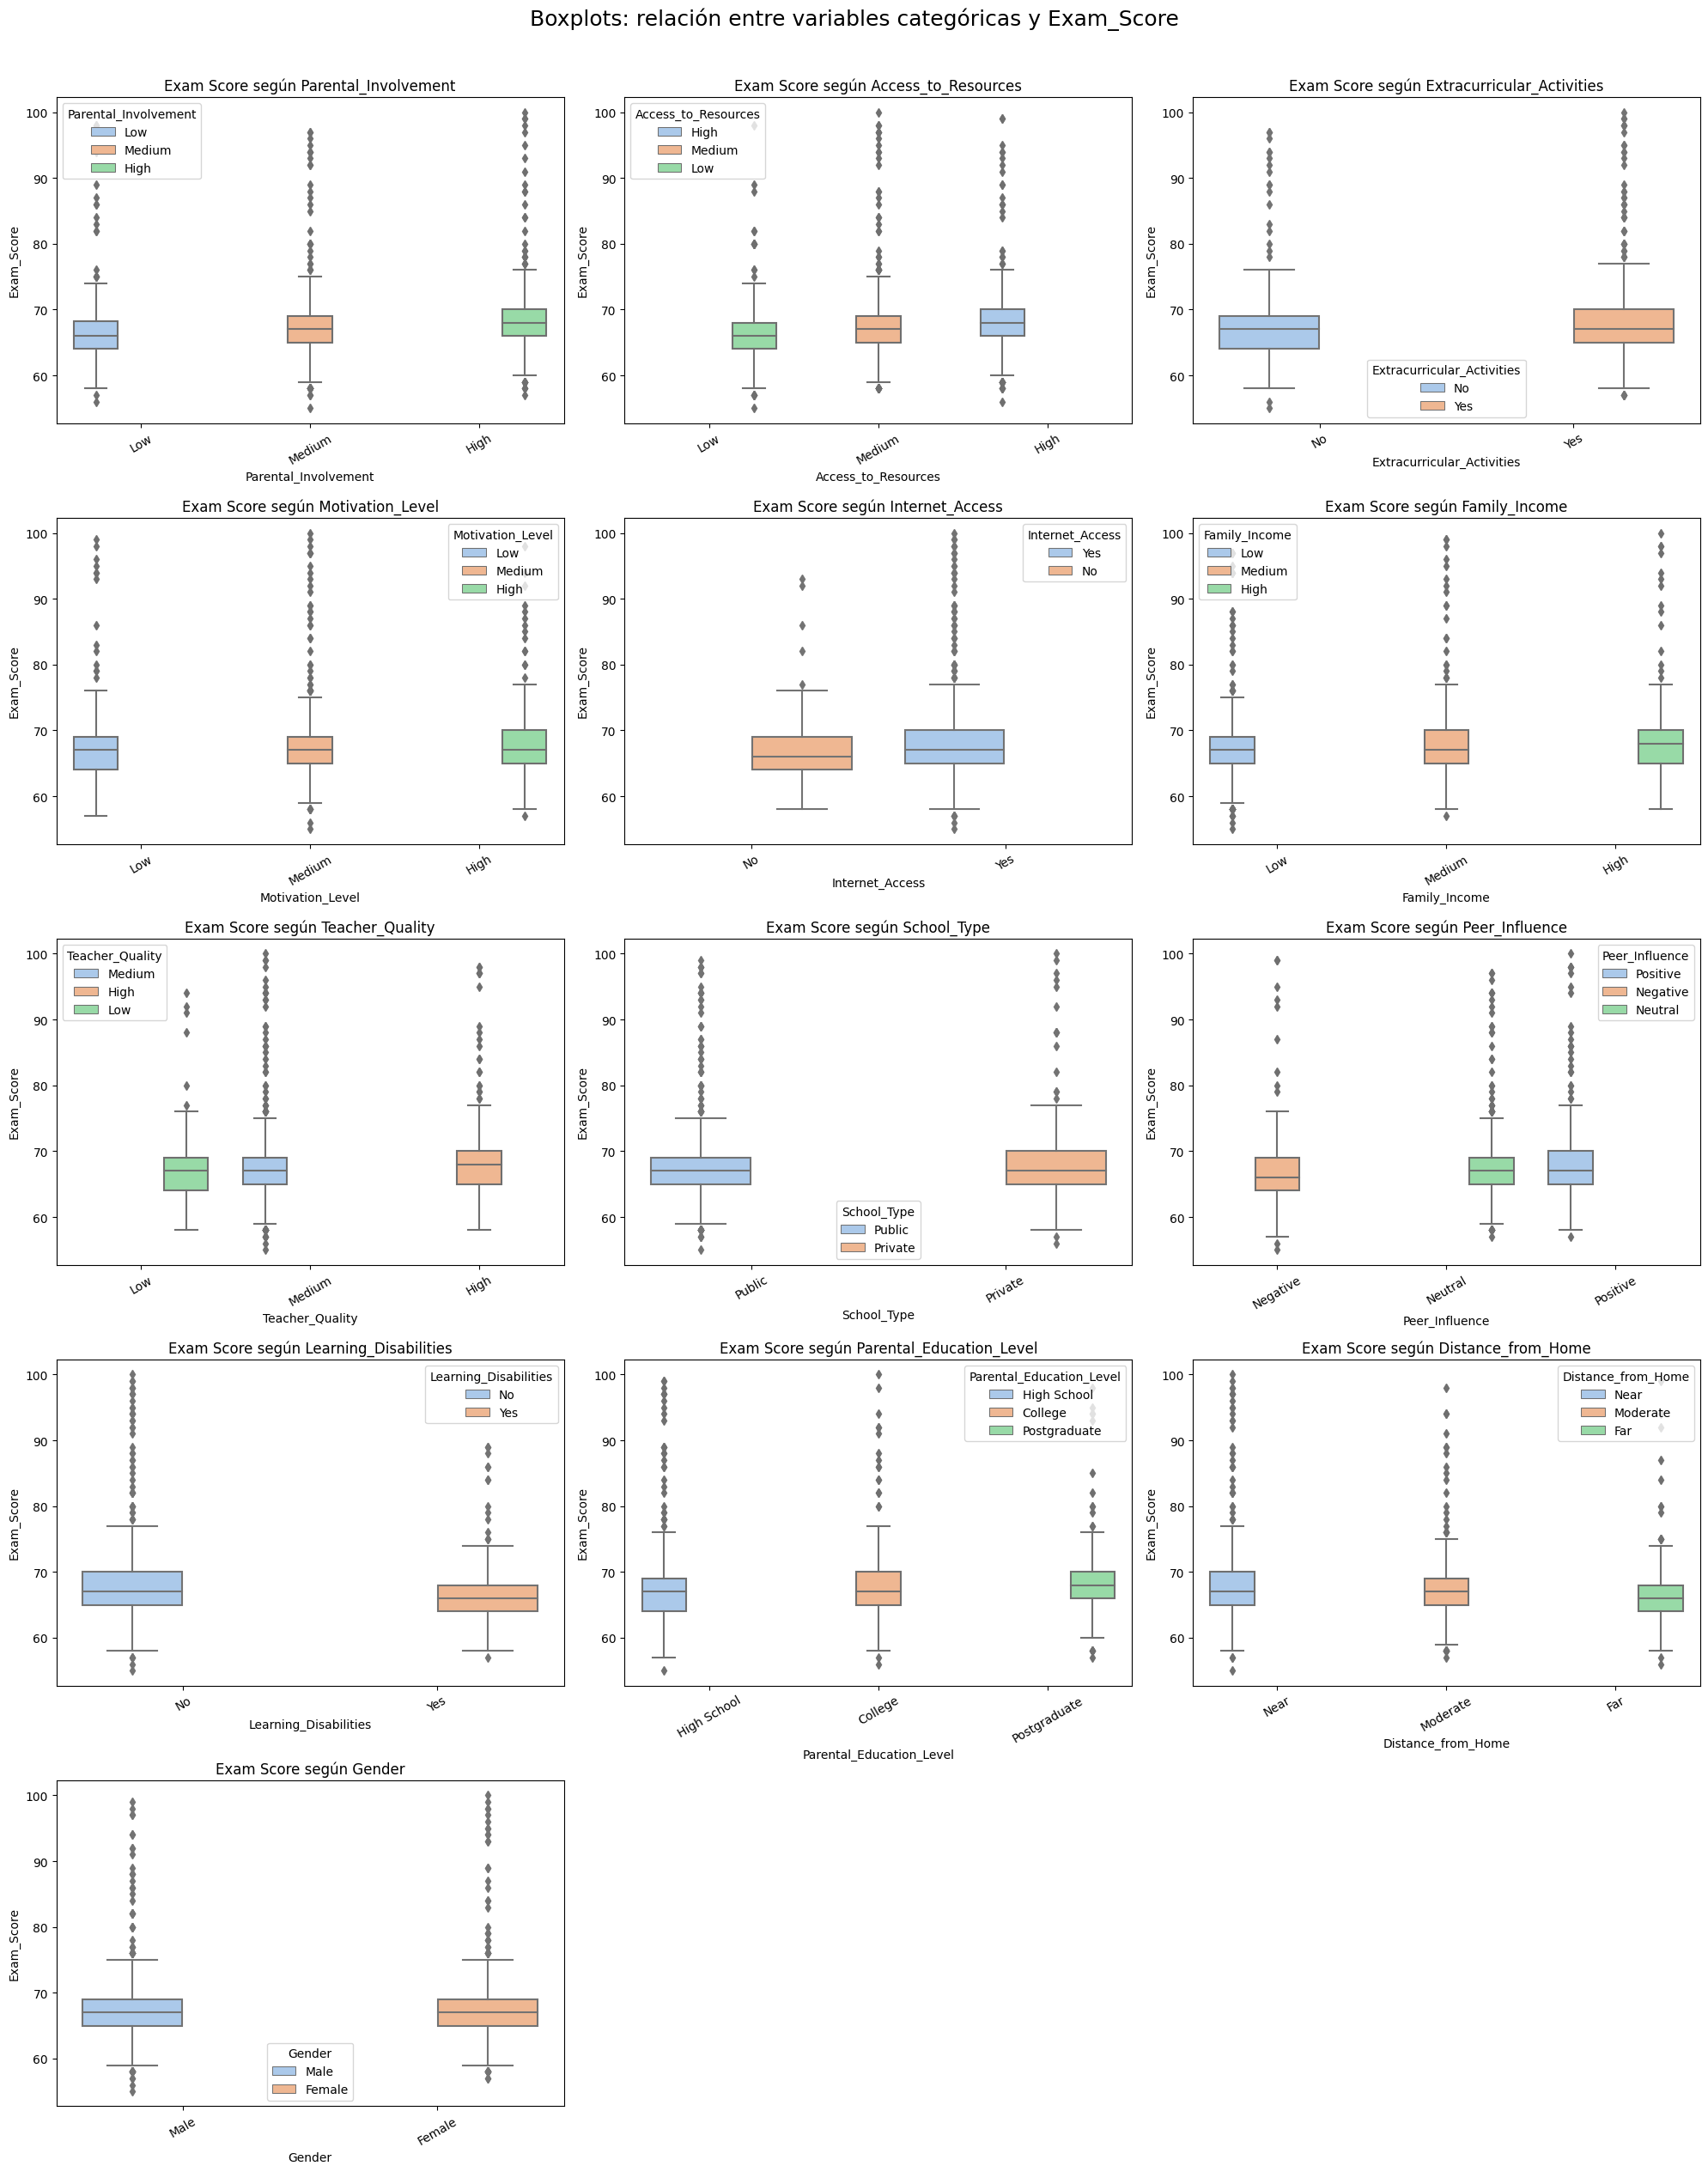

In [21]:
categorical_vars = filled_df.select_dtypes(include='object').columns.tolist()

# Orden personalizado
custom_orders = {
    'Parental_Involvement': ['Low', 'Medium', 'High'],
    'Family_Income': ['Low', 'Medium', 'High'],
    'Motivation_Level': ['Low', 'Medium', 'High'],
    'Teacher_Quality': ['Low', 'Medium', 'High'],
    'Distance_from_Home': ['Near', 'Moderate', 'Far'],
    'Gender': ['Male', 'Female'],
    'Internet_Access': ['No', 'Yes'],
    'Learning_Disabilities': ['No', 'Yes'],
    'School_Type': ['Public', 'Private'],
    'Extracurricular_Activities': ['No', 'Yes'],
    'Access_to_Resources': ['Low', 'Medium', 'High'],
    'Peer_Influence': ['Negative', 'Neutral', 'Positive'],
    'Parental_Education_Level': ['High School', 'College', 'Postgraduate']
}

n_cols = 3
n_rows = (len(categorical_vars) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows), sharey=False)
axes = axes.flatten()

for i, col in enumerate(categorical_vars):
    order = custom_orders.get(col, None)  # Orden personalizado si existe
    sns.boxplot(data=filled_df, x=col, y='Exam_Score', ax=axes[i],hue=col, palette='pastel', order=order)
    axes[i].set_title(f'Exam Score según {col}', fontsize=12)
    axes[i].tick_params(axis='x', rotation=30)

# Quitar subplots vacíos
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Boxplots: relación entre variables categóricas y Exam_Score", fontsize=18, y=1.01)
plt.tight_layout()
plt.show()



Al analizar la relación entre las variables categóricas y el rendimiento académico (`Exam_Score`) mediante boxplots, se observan diferencias sutiles en varias de ellas. Variables como `Motivation_Level`, `Teacher_Quality` y `Distance_from_Home` muestran una ligera tendencia ascendente en el puntaje conforme mejora la categoría, lo que sugiere un posible impacto positivo de estos factores en el rendimiento. Por su parte, `Parental_Involvement`, `Family_Income` y `Peer_Influence` también muestran variaciones en la mediana que podrían resultar útiles para el modelo, aunque con una influencia algo más débil.

En contraste, variables como `Internet_Access` y `Learning_Disabilities` presentan distribuciones prácticamente idénticas entre categorías, lo que indica que probablemente no aporten información relevante al modelo. Además, en el caso de `Learning_Disabilities`, el fuerte desbalance de clases (gran mayoría sin discapacidades) reduce aún más su utilidad. Lo mismo ocurre con `Gender`, donde las diferencias entre grupos son mínimas y la mediana se mantiene estable.

En base a este análisis visual, se seleccionan las siguientes variables categóricas para la construcción del modelo de regresión: `Motivation_Level`, `Teacher_Quality`, `Distance_from_Home`, `Parental_Involvement`, `Family_Income` y `Peer_Influence`, por su mayor estabilidad, interpretación y potencial explicativo sobre `Exam_Score`.


## Data Transformation

Para preparar el conjunto de datos para regresión, se han eliminado las variables categóricas descartadas tras el análisis exploratorio. Se han eliminado variables categóricas y numéricas cuya relación con la variable objetivo (`Exam_Score`) era débil o nula. En particular, variables como `Internet_Access`, `Learning_Disabilities`, `Gender` o `School_Type` mostraban distribuciones muy similares entre categorías, lo que sugiere que no aportan valor predictivo significativo. También se han descartado `Physical_Activity` y `Sleep_Hours` debido a su escasa correlación lineal con el rendimiento académico. Esta limpieza permite reducir el ruido y simplificar el modelo sin perder capacidad explicativa.


In [22]:
df_encoded = filled_df.copy()

# Variables categóricas eliminadas por baja aportación al rendimiento
columns_to_drop = [
    'Internet_Access',              # Distribución homogénea, sin diferencia clara
    'Learning_Disabilities',        # Muy desbalanceada y sin varianza relevante
    'Gender',                       # Diferencia entre grupos mínima
    'School_Type',                  # Sin patrones claros
    'Sleep_Category',               # Solo creada para visualización
    'Access_to_Resources',          # Grupos muy similares
    'Extracurricular_Activities',   # No aporta diferencia significativa
    'Parental_Education_Level',     # Redundante con income/contexto familiar
    'Physical_Activity',            # Correlación casi nula
    'Sleep_Hours'                   # No aporta valor directo
]

# Eliminamos columnas
df_encoded.drop(columns=columns_to_drop, inplace=True, errors='ignore')


### Encoding

Las variables categóricas seleccionadas se han codificado en dos grupos según su naturaleza:

- Las variables ordinales `Motivation_Level` y `Teacher_Quality` se han transformado usando codificación ordinal (`Low < Medium < High`) para conservar su jerarquía implícita.
- Las variables nominales `Distance_from_Home`, `Parental_Involvement`, `Family_Income` y `Peer_Influence` se han codificado mediante one-hot encoding con `drop_first=True` para evitar redundancia entre columnas y mantener la interpretabilidad del modelo.

Esta transformación permite que las variables categóricas sean interpretadas correctamente por modelos que requieren entradas numéricas.


In [23]:
# Codificación ordinal para variables con orden lógico
ordinal_vars = ['Motivation_Level', 'Teacher_Quality']
ordinal_map = [['Low', 'Medium', 'High']] * len(ordinal_vars)
encoder = OrdinalEncoder(categories=ordinal_map)
df_encoded[ordinal_vars] = encoder.fit_transform(df_encoded[ordinal_vars])

# Codificación one-hot para variables nominales
nominal_vars = ['Distance_from_Home', 'Parental_Involvement', 'Family_Income', 'Peer_Influence']
df_encoded = pd.get_dummies(df_encoded, columns=nominal_vars, drop_first=True, dtype=int)
df_encoded.head()

Hours_Studied  Attendance  Previous_Scores  Motivation_Level  \
0             23          84               73               0.0   
1             19          64               59               0.0   
2             24          98               91               1.0   
3             29          89               98               1.0   
4             19          92               65               1.0   

   Tutoring_Sessions  Teacher_Quality  Exam_Score  \
0                  0              1.0          67   
1                  2              1.0          61   
2                  2              1.0          74   
3                  1              1.0          71   
4                  3              2.0          70   

   Distance_from_Home_Moderate  Distance_from_Home_Near  \
0                            0                        1   
1                            1                        0   
2                            0                        1   
3                            1                        0   
4                            0                        1   

   Parental_Involvement_Low  Parental_Involvement_Medium  Family_Income_Low  \
0                         1                            0                  1   
1                         1                            0                  0   
2                         0                            1                  0   
3                         1                            0                  0   
4                         0                            1                  0   

   Family_Income_Medium  Peer_Influence_Neutral  Peer_Influence_Positive  
0                     0                       0                        1  
1                     1                       0                        0  
2                     1                       1                        0  
3                     1                       0                        0  
4                     1                       1                        0

### Escalado

En este análisis, vamos a utilizar dos métodos de escalado para los datos numéricos: StandardScaler y RobustScaler.

- **StandardScaler** : Este método escala las variables para que tengan una media de cero y una desviación estándar de uno. Es ideal para modelos que son sensibles a la escala, como la regresión lineal o los algoritmos basados en distancia (por ejemplo, SVM o KNN).

- **RobustScaler**: Este método escala las características usando la mediana y el rango intercuartílico, lo que lo hace más robusto frente a valores atípicos. Es útil cuando se tienen datos con valores extremos que podrían afectar el modelo.

En las siguientes celdas, aplicaremos ambos escaladores y entrenaremos los modelos con cada uno para comparar sus rendimientos.

## Modelos

En este análisis, se han evaluado varios modelos de regresión utilizando dos métodos de escalado diferentes: **StandardScaler** y **RobustScaler**. Los modelos seleccionados incluyen técnicas clásicas como la **Regresión Lineal**, **Ridge** y **Lasso**, así como modelos basados en árboles como **Decision Tree**, **Random Forest** y **Gradient Boosting**. También se han incluido modelos más complejos como **XGBoost** y **CatBoost**, que son conocidos por su rendimiento superior en tareas de predicción.

Para cada modelo, se realiza una evaluación utilizando **validación cruzada** con 10 particiones y se compara su rendimiento bajo los dos métodos de escalado.  
Debido a que el conjunto de datos es relativamente pequeño, la validación cruzada resulta especialmente útil, ya que permite aprovechar al máximo la información disponible y evita el sesgo que podría producirse al seleccionar un único subconjunto fijo para entrenamiento y prueba.


In [24]:
regressors = [
    ('Linear Regression', LinearRegression()),
    ('Ridge', Ridge()),
    ('Lasso', Lasso()),
    ('KNN', KNeighborsRegressor()),
    ('Decision Tree', DecisionTreeRegressor(random_state=42)),
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('Gradient Boosting', GradientBoostingRegressor(random_state=42)),
    ('AdaBoost', AdaBoostRegressor(random_state=42)),
    ('Bagging', BaggingRegressor(random_state=42)),
    ('XGBoost', XGBRegressor(random_state=42, verbosity=0)),
    ('CatBoost', CatBoostRegressor(random_state=42, verbose=0))
]

Las variables numéricas seleccionadas para el modelo son: `Hours_Studied`, `Attendance`, `Previous_Scores` y `Tutoring_Sessions`. Estas variables han sido normalizadas utilizando `StandardScaler`, lo que garantiza que todas tengan media cero y desviación estándar uno. Este paso es especialmente importante para modelos sensibles a la escala, como la regresión lineal o los algoritmos basados en distancia (por ejemplo, SVM o KNN).


In [25]:
numerical_vars = ['Hours_Studied', 'Attendance', 'Previous_Scores', 'Tutoring_Sessions']

### Evaluación de Modelos con StandardScaler


Primero, aplicamos StandardScaler a las variables numéricas seleccionadas, escalando los datos a una media de 0 y una desviación estándar de 1. A continuación, evaluamos varios modelos de regresión utilizando validación cruzada con 10 particiones.

In [26]:
# Escalado con StandardScaler
scaler = StandardScaler()
df_enc = df_encoded.copy()
df_enc[numerical_vars] = scaler.fit_transform(df_enc[numerical_vars])

# Variables predictoras y target
X = df_enc.drop(columns='Exam_Score')
y = df_enc['Exam_Score']

# KFold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Evaluación de modelos sin prints extras en la barra tqdm
results_standard = {}
pbar = tqdm(regressors, desc="Evaluando con StandardScaler", ncols=100)

for name, model in pbar:
    pbar.set_postfix_str(name)  # Solo muestra el modelo actual en la barra
    scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
    results_standard[name] = scores

pbar.close()

# DataFrame de resultados
cv_scores_standard_df = pd.DataFrame(results_standard)


Evaluando con StandardScaler: 100%|███████████████████████| 11/11 [00:49<00:00,  4.53s/it, CatBoost]


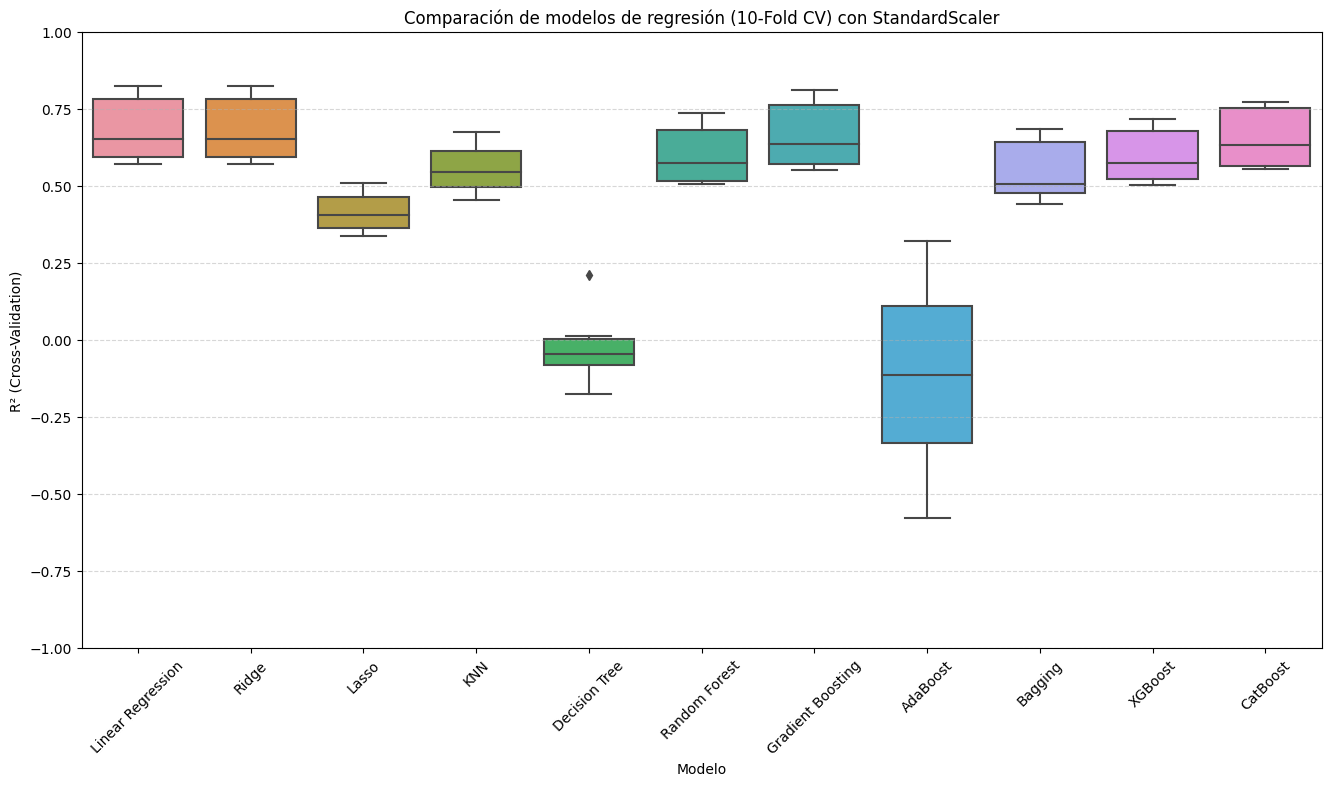

In [27]:
plt.figure(figsize=(16, 8))
sns.boxplot(data=cv_scores_standard_df)
plt.xticks(rotation=45)
plt.xlabel("Modelo")
plt.ylabel("R² (Cross-Validation)")
plt.title("Comparación de modelos de regresión (10-Fold CV) con StandardScaler")
plt.ylim(-1,1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

El gráfico muestra la comparación del rendimiento de distintos modelos de regresión aplicando validación cruzada con 10 particiones. Se ha utilizado como métrica el coeficiente de determinación R². Modelos como `CatBoost`, `XGBoost`, `Gradient Boosting` y `Random Forest` han obtenido mejores resultados, con puntuaciones medias elevadas y baja varianza. En contraste, `AdaBoost` y `Decision Tree` han mostrado un rendimiento inferior, con valores incluso negativos en algunos folds, lo que indica una capacidad predictiva deficiente sin ajuste de hiperparámetros. 

### Evaluación de Modelos con RobustScaler


Ahora, aplicamos RobustScaler a las variables numéricas seleccionadas, escalando los datos usando la mediana y el rango intercuartílico. Este escalador es menos sensible a los valores atípicos. Procedemos a evaluar los mismos modelos con validación cruzada utilizando RobustScaler.


In [28]:
from tqdm import tqdm

# Escalado con RobustScaler
scaler = RobustScaler()
df_enc = df_encoded.copy()
df_enc[numerical_vars] = scaler.fit_transform(df_enc[numerical_vars])

# Variables predictoras y target
X = df_enc.drop(columns='Exam_Score')
y = df_enc['Exam_Score']

# KFold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Evaluación de modelos sin impresión extra en la barra de carga tqdm
results_robust = {}
pbar = tqdm(regressors, desc="Evaluando con Robust Scaler", ncols=120)

for name, model in pbar:
    pbar.set_postfix_str(name)  # Solo actualiza nombre en la barra
    
    scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
    results_robust[name] = scores

pbar.close()

# DataFrame de resultados
cv_scores_robust_df = pd.DataFrame(results_robust)


Evaluando con Robust Scaler: 100%|████████████████████████████████████████████| 11/11 [00:49<00:00,  4.50s/it, CatBoost]


### Resultados

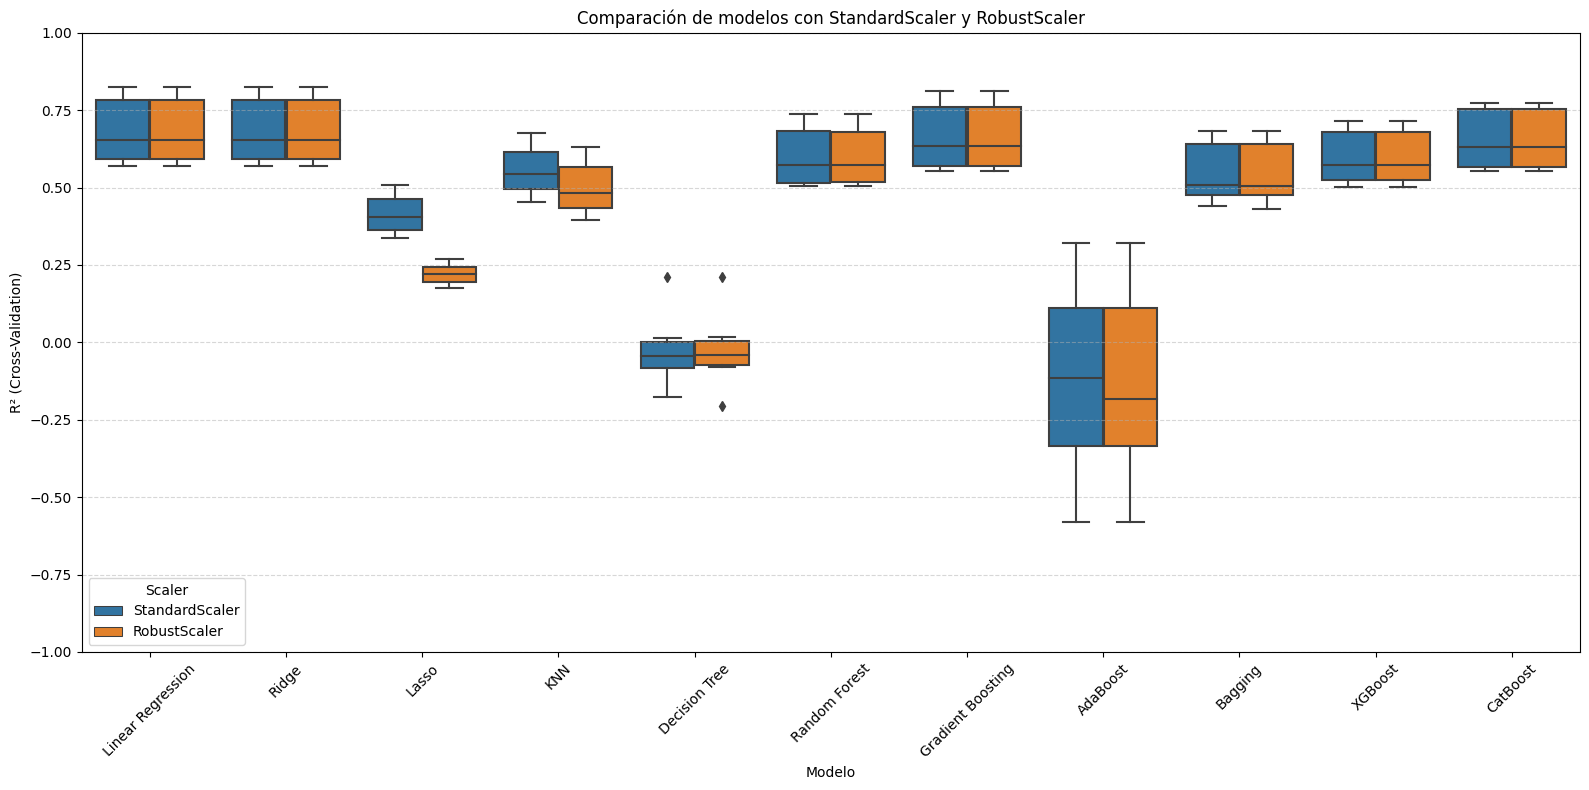

In [29]:

# Datos con resultados de validación cruzada para cada modelo y tipo de scaler
results_standard_df = pd.DataFrame(results_standard)
results_standard_df = results_standard_df.T
results_standard_df = results_standard_df.reset_index()
results_standard_df.columns = ['Model'] + [f'Fold_{i+1}' for i in range(10)]
results_standard_df['Scaler'] = 'StandardScaler'

results_robust_df = pd.DataFrame(results_robust)
results_robust_df = results_robust_df.T
results_robust_df = results_robust_df.reset_index()
results_robust_df.columns = ['Model'] + [f'Fold_{i+1}' for i in range(10)]
results_robust_df['Scaler'] = 'RobustScaler'

# Combinar los resultados en un único DAtaFrame
cv_scores_combined_df = pd.concat([results_standard_df, results_robust_df])

# Convertir los resultados de los folds en formato largo para seaborn (necesario para boxplot)
cv_scores_combined_long_df = pd.melt(cv_scores_combined_df, id_vars=['Model', 'Scaler'], 
                                     value_vars=[f'Fold_{i+1}' for i in range(10)],
                                     var_name='Fold', value_name='R²')

# Boxplot de comparación con 'hue' para distinguir entre los dos scalers
plt.figure(figsize=(16, 8))
sns.boxplot(data=cv_scores_combined_long_df, x='Model', y='R²', hue='Scaler')
plt.xticks(rotation=45)
plt.xlabel("Modelo")
plt.ylabel("R² (Cross-Validation)")
plt.title("Comparación de modelos con StandardScaler y RobustScaler")
plt.ylim(-1, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


El gráfico muestra que, en general, `StandardScaler` ofrece un rendimiento ligeramente superior a `RobustScaler` en la mayoría de los modelos, con una mayor consistencia en modelos como `Linear Regression` y `Ridge`. Sin embargo, `RobustScaler` tiene un rendimiento similar en modelos como `XGBoost` y `CatBoost`. Los modelos como `AdaBoost` y `Decision Tree` muestran una mayor variabilidad, especialmente con `RobustScaler`, que presenta valores negativos en algunos folds.

### Tuneo de Hiperparametros para Árbol de decisión

Para mejorar el rendimiento del árbol de decisión sin agotar recursos en búsquedas extensas, se empleó una combinación de `RandomizedSearchCV` y `GridSearchCV`. La primera etapa permite explorar rápidamente un espacio amplio y variado de hiperparámetros mediante muestreo aleatorio. Una vez localizada una configuración prometedora, se afina la búsqueda en torno a esos valores usando `GridSearchCV`, lo que facilita encontrar una configuración más óptima sin probar combinaciones innecesarias. 

NOTA: tras ver los resultados, se ha decidido usar como scaler: StandardScaler


In [30]:

from scipy.stats import randint

# Escalado con StandardScaler
scaler = StandardScaler()
df_enc=df_encoded.copy()
df_enc[numerical_vars] = scaler.fit_transform(df_enc[numerical_vars])

# Variables predictoras y target
X = df_enc.drop(columns='Exam_Score')
y = df_enc['Exam_Score']



# Paso 1: RandomizedSearchCV (búsqueda amplia)
random_search = RandomizedSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_distributions={
        'max_depth': randint(3, 15),
        'min_samples_split': randint(2, 15),
        'min_samples_leaf': randint(1, 8),
        'max_features': [None, 'sqrt', 'log2']
    },
    n_iter=30,
    cv=10, # 10 folds Cross Validation
    scoring='r2',
    random_state=42,
    n_jobs=1,
    verbose=1
)

random_search.fit(X, y)

print("Mejor configuración inicial (RandomizedSearch):")
print(random_search.best_params_)

# Paso 2: GridSearchCV (ajuste fino alrededor del mejor)
best_params = random_search.best_params_
param_grid = {
    'max_depth': [max(3, best_params['max_depth'] - 1), best_params['max_depth'], best_params['max_depth'] + 1],
    'min_samples_split': [max(2, best_params['min_samples_split'] - 1), best_params['min_samples_split'], best_params['min_samples_split'] + 1],
    'min_samples_leaf': [best_params['min_samples_leaf']],
    'max_features': [best_params['max_features']]
}

grid_search = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_grid=param_grid,
    cv=10, # 10 folds Cross Validation
    scoring='r2',
    n_jobs=1,
    verbose=1
)

grid_search.fit(X, y)

# Guardamos el mejor modelo
best_tree = grid_search.best_estimator_

print("Mejor configuración final (GridSearch):")
print(grid_search.best_params_)
print(f"Mejor puntuación R²: {grid_search.best_score_:.3f}")


Fitting 10 folds for each of 30 candidates, totalling 300 fits
Mejor configuración inicial (RandomizedSearch):
{'max_depth': 8, 'max_features': None, 'min_samples_leaf': 7, 'min_samples_split': 3}
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Mejor configuración final (GridSearch):
{'max_depth': 8, 'max_features': None, 'min_samples_leaf': 7, 'min_samples_split': 2}
Mejor puntuación R²: 0.533


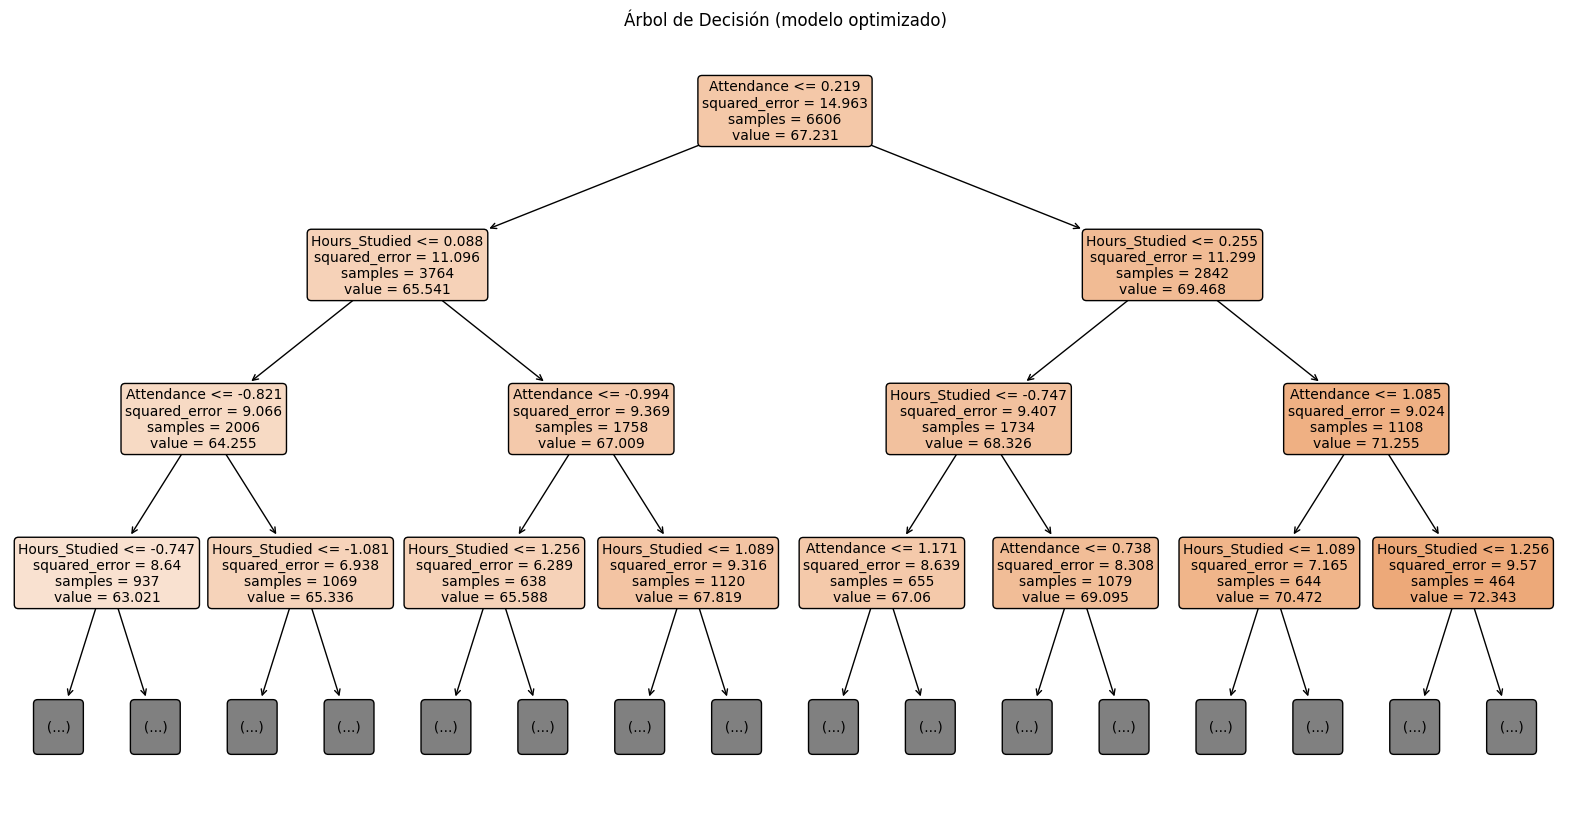

In [31]:

# Visualizar hasta nivel 3 para mejor legibilidad
plt.figure(figsize=(20, 10))
plot_tree(
    best_tree,
    feature_names=X.columns,
    filled=True,
    rounded=True,
    max_depth=3,
    fontsize=10
)
plt.title("Árbol de Decisión (modelo optimizado)")
plt.show()


Tras aplicar una estrategia combinada de ajuste de hiperparámetros (`RandomizedSearchCV` seguido de `GridSearchCV`), se identificó como mejor configuración: `max_depth=7`, `min_samples_leaf=7`, `min_samples_split=2`, y `max_features=None`. Esta configuración alcanzó una puntuación R² promedio de **0.533**, lo que representa una ligera considerable ya que sin realizar este tuning, se habían obtenido R² cercanos a 0.

Al visualizar la estructura del árbol (limitada a una profundidad de 3 para facilitar la interpretación), se observa que las variables más relevantes en las primeras divisiones siguen siendo `Attendance` y `Hours_Studied`, en línea con los análisis de correlación anteriores. En detalle:

- El nodo raíz segmenta según `Attendance`, separando a los estudiantes con baja asistencia del resto.
- A continuación, el árbol utiliza `Hours_Studied` como criterio de división en varios niveles, ajustando las predicciones según el tiempo de estudio.
- La predicción media del examen tiende a aumentar conforme se combinan altos niveles de asistencia con más horas de estudio.

Esto refuerza la idea de que los hábitos académicos básicos, como asistir a clase y dedicar tiempo al estudio, son los principales predictores del rendimiento. 

# Parte 1: Clasificación

### Exploración y Preprocesamiento

El conjunto de datos de alubias secas (`Dry Bean Dataset`) está compuesto por 16 variables numéricas que describen distintas propiedades geométricas y morfológicas de los granos. Estas se pueden agrupar en dos grandes bloques: 
- **medidas relacionadas con el tamaño** del grano, como `Area`, `Perimeter`, `MajorAxisLength`, `MinorAxisLength`, `ConvexArea` o `EquivDiameter`, que están altamente correlacionadas entre sí.
- **medidas relacionadas con la forma**, como `AspectRation`, `Eccentricity`, `Solidity`, `Extent`, `Compactness`, `Roundness` y las variables `ShapeFactor1` a `ShapeFactor4`. 

Estas últimas capturan detalles como la elongación, redondez o simetría del grano, lo que puede ser especialmente útil para diferenciar entre clases con tamaños similares pero formas distintas.

In [32]:
beans_df = pd.read_excel("/kaggle/input/dry-bean-dataset/Dry_Bean_Dataset/Dry_Bean_Dataset.xlsx")

print("Dimensiones del dataset:", beans_df.shape)
beans_df.info()
beans_df.describe()

Dimensiones del dataset: (13611, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13611 entries, 0 to 13610
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             13611 non-null  int64  
 1   Perimeter        13611 non-null  float64
 2   MajorAxisLength  13611 non-null  float64
 3   MinorAxisLength  13611 non-null  float64
 4   AspectRation     13611 non-null  float64
 5   Eccentricity     13611 non-null  float64
 6   ConvexArea       13611 non-null  int64  
 7   EquivDiameter    13611 non-null  float64
 8   Extent           13611 non-null  float64
 9   Solidity         13611 non-null  float64
 10  roundness        13611 non-null  float64
 11  Compactness      13611 non-null  float64
 12  ShapeFactor1     13611 non-null  float64
 13  ShapeFactor2     13611 non-null  float64
 14  ShapeFactor3     13611 non-null  float64
 15  ShapeFactor4     13611 non-null  float64
 16  Class            1361

Area     Perimeter  MajorAxisLength  MinorAxisLength  \
count   13611.000000  13611.000000     13611.000000     13611.000000   
mean    53048.284549    855.283459       320.141867       202.270714   
std     29324.095717    214.289696        85.694186        44.970091   
min     20420.000000    524.736000       183.601165       122.512653   
25%     36328.000000    703.523500       253.303633       175.848170   
50%     44652.000000    794.941000       296.883367       192.431733   
75%     61332.000000    977.213000       376.495012       217.031741   
max    254616.000000   1985.370000       738.860153       460.198497   

       AspectRation  Eccentricity     ConvexArea  EquivDiameter        Extent  \
count  13611.000000  13611.000000   13611.000000   13611.000000  13611.000000   
mean       1.583242      0.750895   53768.200206     253.064220      0.749733   
std        0.246678      0.092002   29774.915817      59.177120      0.049086   
min        1.024868      0.218951   20684.000000     161.243764      0.555315   
25%        1.432307      0.715928   36714.500000     215.068003      0.718634   
50%        1.551124      0.764441   45178.000000     238.438026      0.759859   
75%        1.707109      0.810466   62294.000000     279.446467      0.786851   
max        2.430306      0.911423  263261.000000     569.374358      0.866195   

           Solidity     roundness   Compactness  ShapeFactor1  ShapeFactor2  \
count  13611.000000  13611.000000  13611.000000  13611.000000  13611.000000   
mean       0.987143      0.873282      0.799864      0.006564      0.001716   
std        0.004660      0.059520      0.061713      0.001128      0.000596   
min        0.919246      0.489618      0.640577      0.002778      0.000564   
25%        0.985670      0.832096      0.762469      0.005900      0.001154   
50%        0.988283      0.883157      0.801277      0.006645      0.001694   
75%        0.990013      0.916869      0.834270      0.007271      0.002170   
max        0.994677      0.990685      0.987303      0.010451      0.003665   

       ShapeFactor3  ShapeFactor4  
count  13611.000000  13611.000000  
mean       0.643590      0.995063  
std        0.098996      0.004366  
min        0.410339      0.947687  
25%        0.581359      0.993703  
50%        0.642044      0.996386  
75%        0.696006      0.997883  
max        0.974767      0.999733

Se ha cargado correctamente el dataset `Dry_Bean_Dataset`, compuesto por 13,611 muestras y 17 columnas. Todas las variables predictoras son de tipo numérico (`int64` o `float64`), mientras que la variable objetivo `Class` es categórica. No se han detectado valores nulos, por lo que no es necesario aplicar técnicas de imputación en esta etapa.


### Visualización

Antes de aplicar modelos de regresión, es conveniente realizar una exploración visual básica del dataset. Esto permite observar la distribución de la variable objetivo `Class` y detectar posibles relaciones entre las variables numéricas que podrían influir en el rendimiento académico.



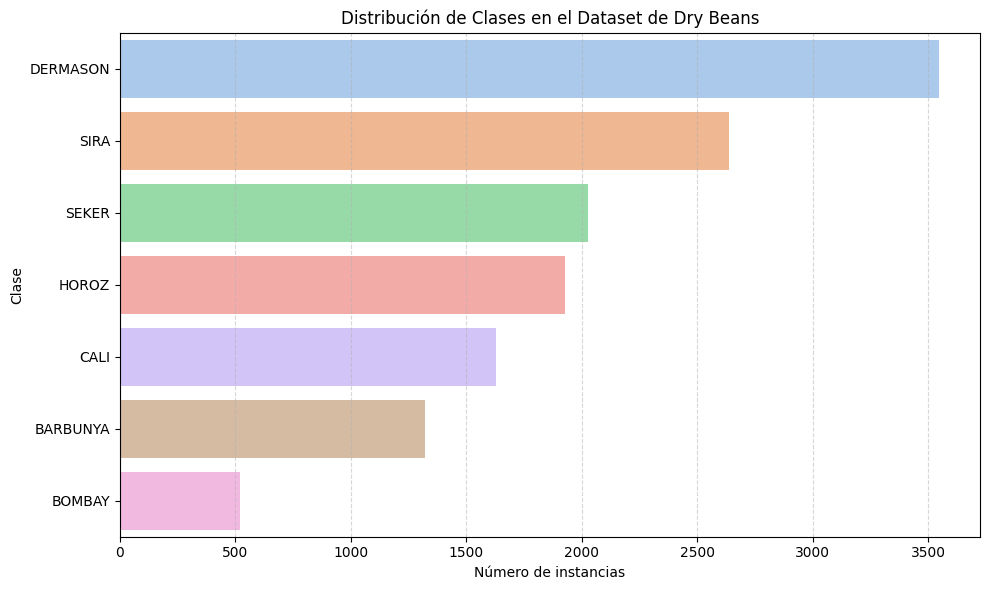

In [33]:
# Conteo de clases
beans_counts = beans_df['Class'].value_counts().reset_index()
beans_counts.columns = ['Class', 'count']

plt.figure(figsize=(10, 6))
sns.barplot(data=beans_counts, y="Class", x="count", palette="pastel", hue="Class", dodge=False)
plt.title("Distribución de Clases en el Dataset de Dry Beans")
plt.xlabel("Número de instancias")
plt.ylabel("Clase")
plt.legend([],[], frameon=False)  # Oculta leyenda duplicada
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


El dataset de Dry Beans contiene 7 clases diferentes, con una distribución de instancias desigual. La clase `DERMASON` es la más representada, con 3546 muestras, seguida por `SIRA` con 2636 instancias. En el otro extremo, la clase `BOMBAY` tiene solo 522 muestras, lo que indica un desbalance significativo entre las clases. Este desbalance podría afectar la capacidad del modelo para generalizar ypor lo que las clases minoritarias podrían necesitar técnicas de sobremuestreo o ajuste de pesos para mejorar su rendimiento.

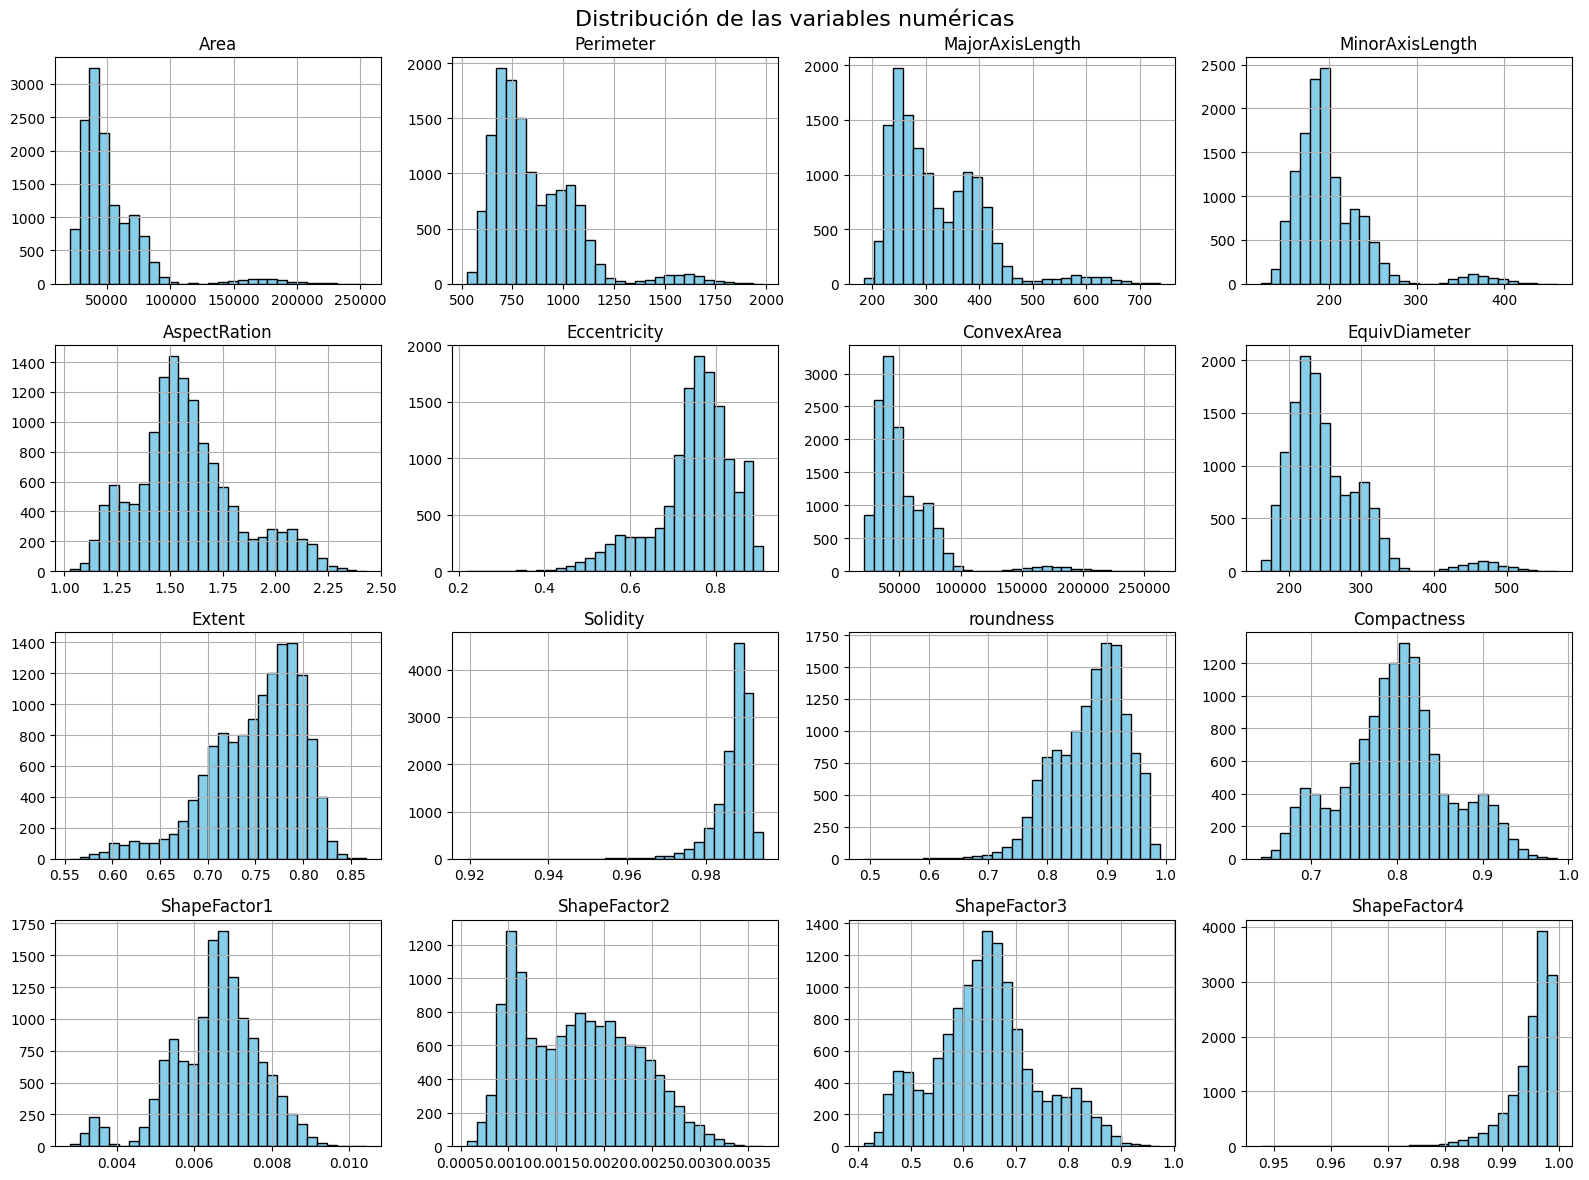

In [34]:
beans_df.drop(columns="Class").hist(bins=30, figsize=(16, 12), edgecolor='black', color='skyblue')
plt.suptitle("Distribución de las variables numéricas", fontsize=16)
plt.tight_layout()
plt.show()


La distribución de las variables numéricas muestra que la mayoría de ellas no siguen una distribución normal. Algunas, como `Area`, `Perimeter` o `ConvexArea`, presentan una fuerte asimetría a la derecha, lo que sugiere la presencia de valores extremos o clases con tamaños significativamente diferentes. Otras variables como `Solidity`, `ShapeFactor4` o `Compactness` están fuertemente concentradas en un rango estrecho, lo que indica poca variabilidad, aunque podrían seguir aportando información discriminativa.


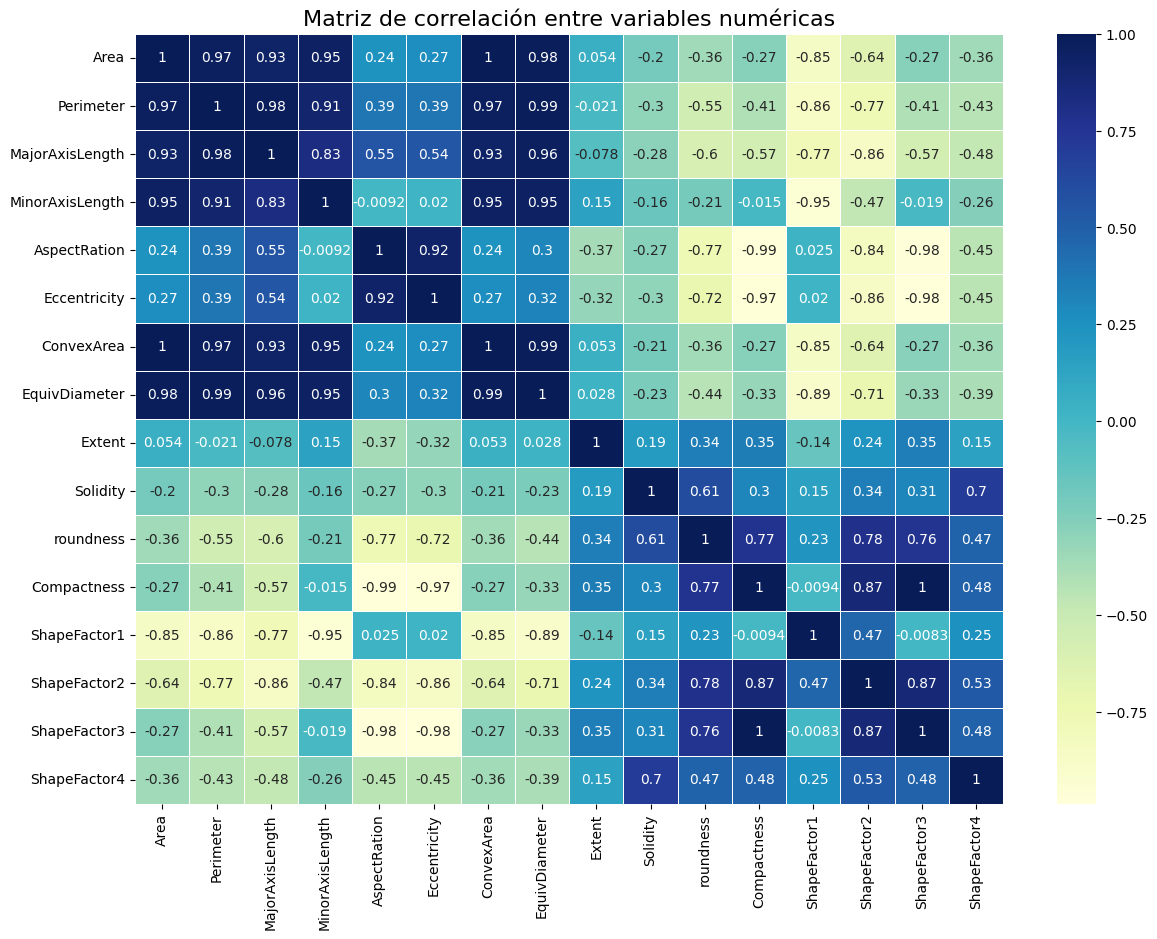

In [35]:
plt.figure(figsize=(14, 10))
sns.heatmap(beans_df.drop(columns="Class").corr(), annot=True, cmap="YlGnBu", linewidths=0.5)
plt.title("Matriz de correlación entre variables numéricas", fontsize=16)
plt.show()


La matriz de correlación revela una **fuerte multicolinealidad** entre ciertas variables, especialmente entre `Area`, `Perimeter`, `ConvexArea`, `EquivDiameter`, `MajorAxisLength` y `MinorAxisLength`, con coeficientes de correlación cercanos o superiores a 0.95. Esta fuerte correlación se debe a que todas estas variables describen aspectos **relacionados con el tamaño físico de la semilla**: una semilla más grande tendrá inevitablemente un área mayor, un perímetro más largo y dimensiones axiales más extensas. Por ejemplo, el diámetro equivalente (`EquivDiameter`) es una transformación del área, mientras que `ConvexArea` es una medida del área del casco convexo, altamente dependiente del tamaño general.

En contraste, variables como `AspectRation`, `Eccentricity`, `Solidity`, `Compactness` o los `ShapeFactor` representan características más **geométricas o estructurales**: proporciones, simetría, redondez, etc. Estas no dependen directamente del tamaño, sino de la forma o distribución del área. Por eso, su correlación con las variables de tamaño es mucho menor, e incluso puede ser negativa.

Este análisis es fundamental para evitar la redundancia de información al entrenar modelos predictivos, ya que variables altamente correlacionadas pueden sesgar el aprendizaje. También sirve para identificar qué variables son realmente independientes y aportan **información única**

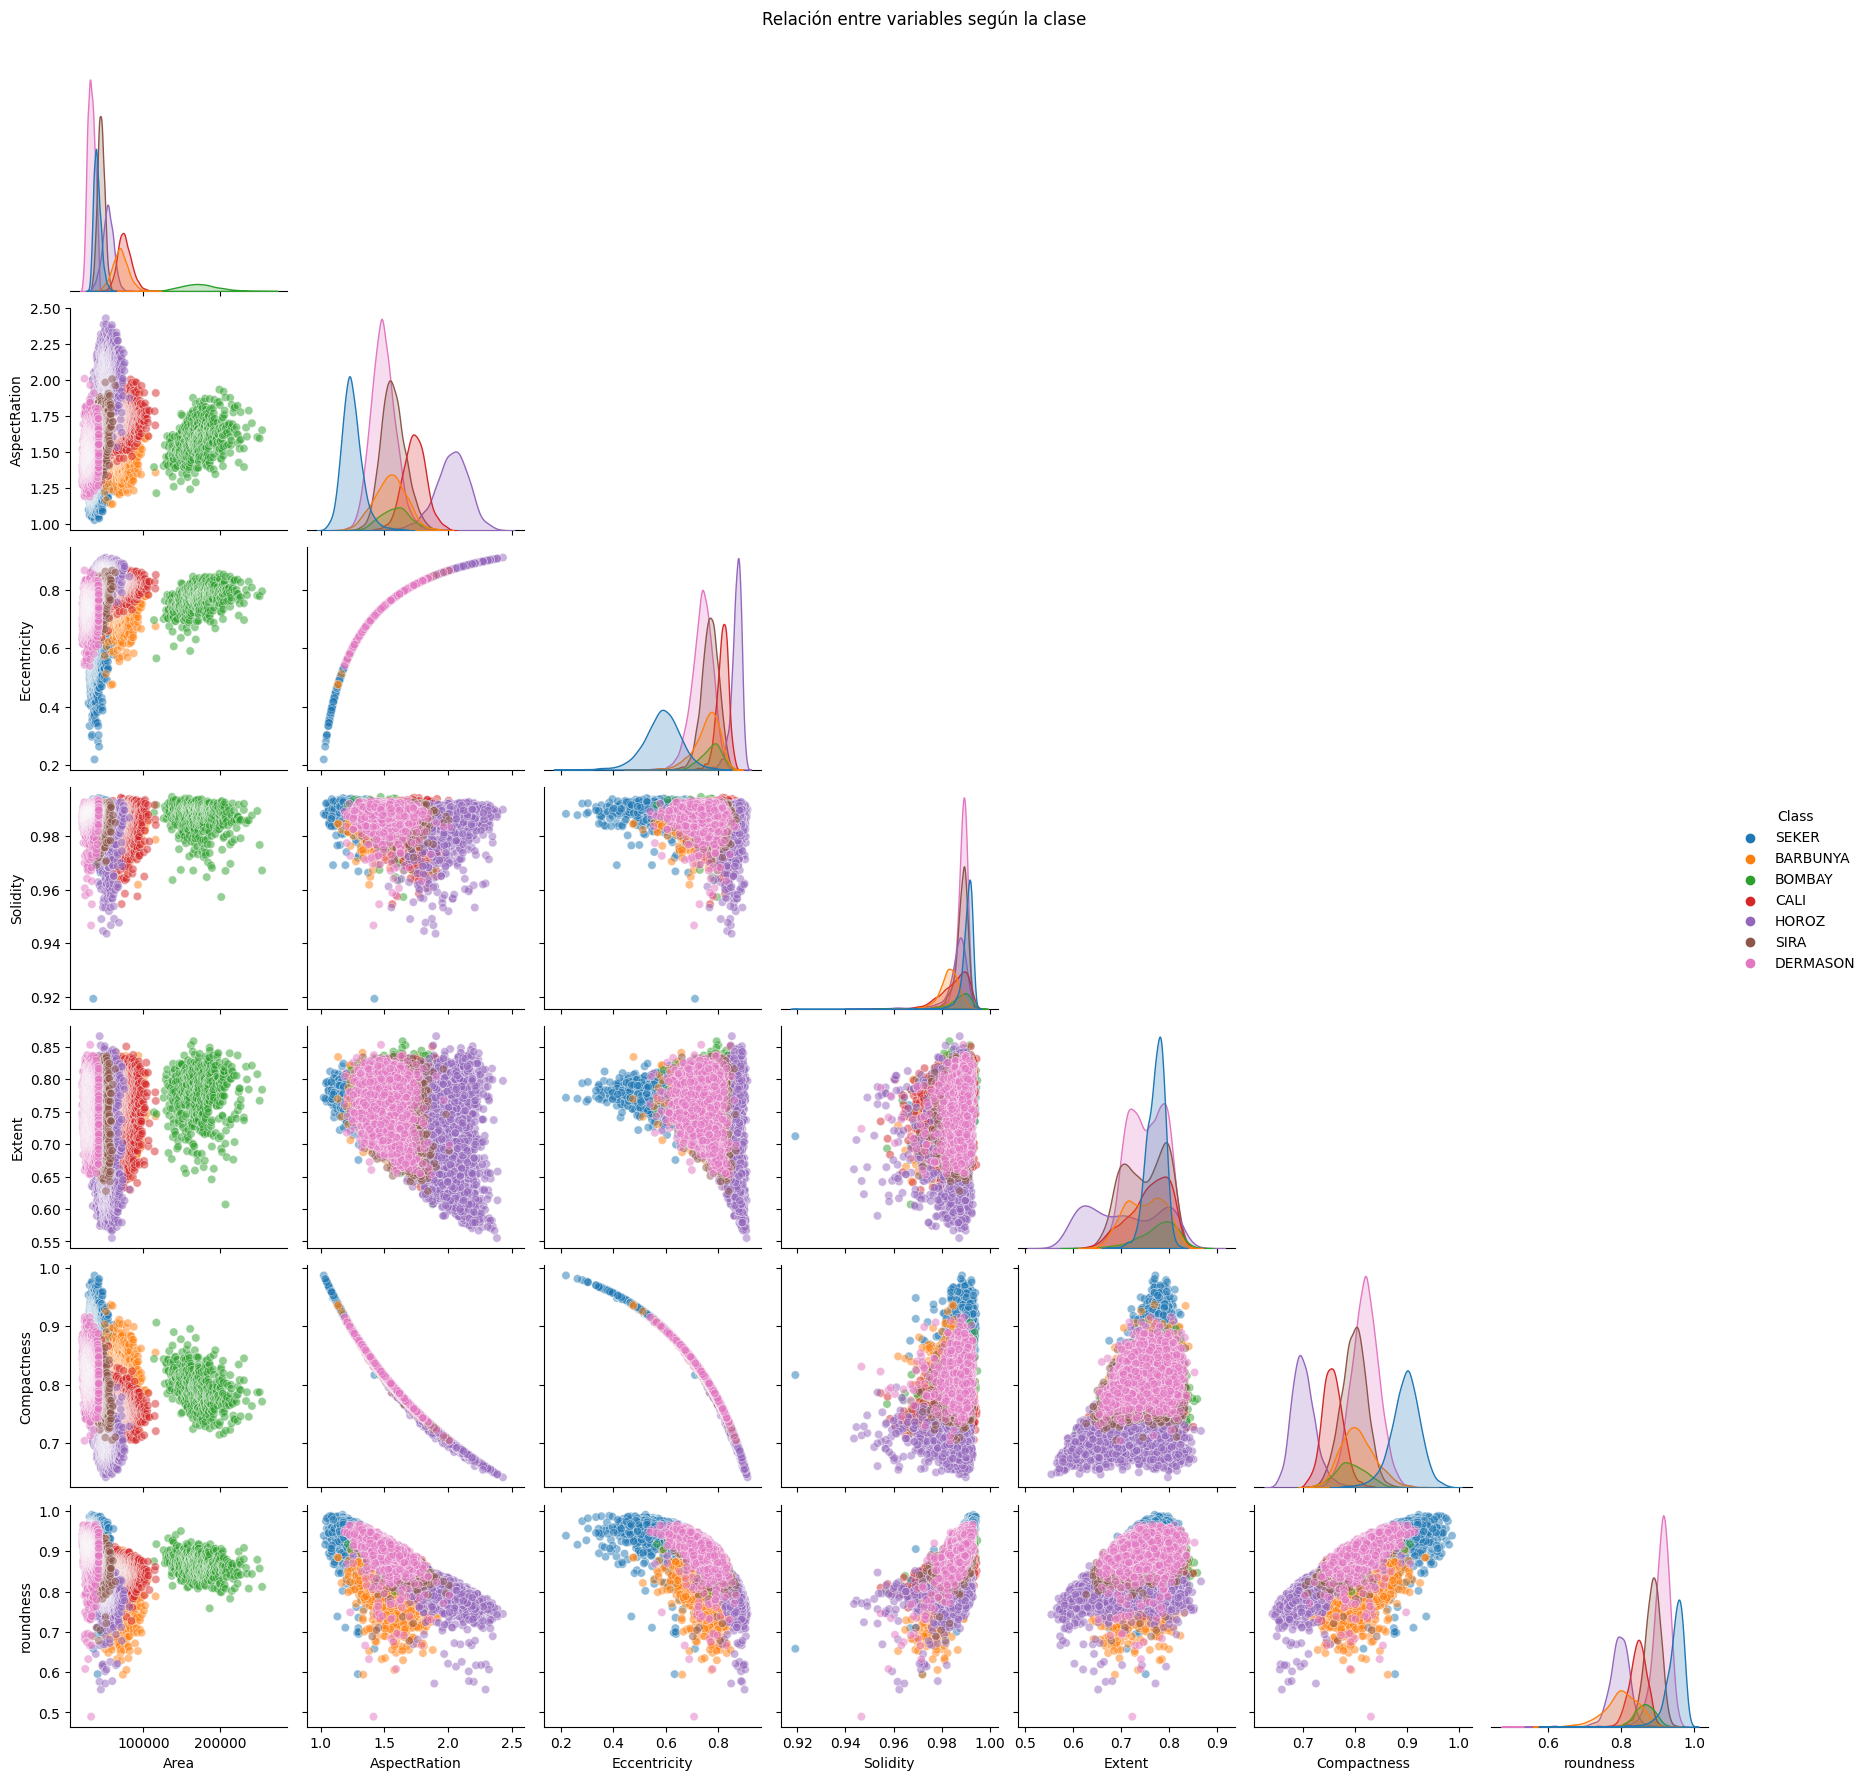

In [36]:
# Seleccionamos un subconjunto de variables relevantes sin multicolinealidad
subset_vars = ['Area', 'AspectRation', 'Eccentricity', 'Solidity', 'Extent', 'Compactness', 'roundness']


sns.pairplot(beans_df[subset_vars + ["Class"]], hue="Class", diag_kind="kde", corner=True, plot_kws={"alpha": 0.5})
plt.suptitle("Relación entre variables según la clase", y=1.02)
plt.show()


Dado que trabajar con las 16 variables originales del conjunto de datos podría dificultar la interpretación visual debido a la presencia de multicolinealidad, se ha optado por seleccionar un subconjunto de variables representativas que no presentan alta correlación entre sí (coeficientes de correlación < 0.75). Esta selección permite evitar la redundancia informativa y facilita una visualización más clara y efectiva.

Las variables elegidas para el análisis fueron:

- **Area**
- **AspectRation**
- **Eccentricity**
- **Solidity**
- **Extent**
- **Compactness**
- **roundness**

Estas variables fueron seleccionadas por aportar perspectivas complementarias sobre la morfología de las muestras, manteniendo la independencia relativa entre sí. El gráfico `pairplot` generado permite observar la distribución conjunta de estas variables según la clase de judía. Se aprecian patrones de dispersión distintivos para algunas clases, como `BOMBAY`, que se agrupa en una región bien delimitada del espacio de variables. Otras clases, como `DERMASON`, `SIRA` y `SEKER`, presentan cierta superposición, aunque conservan estructuras de agrupación reconocibles. Esta representación gráfica es útil para identificar la separabilidad entre clases y validar visualmente el potencial discriminativo de las variables seleccionadas, lo cual es clave para el desarrollo de modelos de clasificación robustos.


### Clasificación tradicional configuración de clasificadores, técnicas de escalado y balanceo


Esta sección evalúa el rendimiento de modelos clásicos de clasificación (Decision Tree, SVM, KNN) bajo distintas combinaciones de técnicas de escalado (`None`, `StandardScaler`, `RobustScaler`) y estrategias de balanceo (`None`, `oversample`, `undersample`, `balance_median`). Se utiliza `Pipeline` para integrar cada escalador con el clasificador correspondiente, garantizando un flujo limpio y sin data leakage.


#### División de datos y normalización

Como primer paso del preprocesamiento, se realiza una **división estratificada** del conjunto de datos en entrenamiento y validación, asegurando que la distribución de clases se mantenga en ambos subconjuntos. Esta técnica permite una representación equitativa de las distintas clases tanto en el entrenamiento como en la validación, lo cual es especialmente importante en problemas de clasificación multiclase.

En este caso, no se utiliza validación cruzada, ya que el conjunto de datos es considerablemente más grande que en el análisis anterior. Al contar con una cantidad de muestras mucho mayor, una única partición estratificada entre entrenamiento y validación es suficiente para obtener estimaciones fiables del rendimiento del modelo sin incurrir en altos costes computacionales.


In [37]:
# 1. Separar variables predictoras y objetivo
X = beans_df.drop(columns=['Class'])
y = beans_df['Class']

# 2. Codificar etiquetas 
le = LabelEncoder()
y_enc = le.fit_transform(y)

# 3. División estratificada en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(
    X, y_enc, test_size=0.2, stratify=y_enc, random_state=42
)


#### Función de resampling para reducir sesgo

En tareas de clasificación con clases desbalanceadas, como ocurre en este dataset, los modelos tienden a sesgarse hacia las clases mayoritarias. Para mitigar este efecto, se han aplicado tres estrategias de resampleo sobre los datos de entrenamiento:

- **Oversampling**: amplifica las clases minoritarias replicando instancias existentes.
- **Undersampling**: reduce el tamaño de las clases mayoritarias.
- **Balanceo a la mediana**: ajusta todas las clases a un tamaño intermedio, combinando oversampling y undersampling.

Estas variantes se evaluarán utilizando distintos clasificadores, comparando su rendimiento con el modelo entrenado sobre los datos originales. El análisis se realizará a partir de métricas adecuadas como F1‑macro para valorar su impacto.

In [41]:
def apply_resampling(X, y, method=None):
    y_counts = dict(Counter(y))
    
    if method == 'oversample':
        return RandomOverSampler(sampling_strategy='not majority', random_state=42).fit_resample(X, y)
    
    elif method == 'undersample':
        return RandomUnderSampler(sampling_strategy='not minority', random_state=42).fit_resample(X, y)
    
    elif method == 'balance_median':
        median_n = int(np.median(list(y_counts.values())))
        over_strategy = {cls: median_n for cls, cnt in y_counts.items() if cnt < median_n}
        under_strategy = {cls: median_n for cls, cnt in y_counts.items() if cnt > median_n}
        
        # Aplicar manualmente
        X_tmp, y_tmp = RandomOverSampler(sampling_strategy=over_strategy, random_state=42).fit_resample(X, y)
        return RandomUnderSampler(sampling_strategy=under_strategy, random_state=42).fit_resample(X_tmp, y_tmp)
    
    return X, y


#### Distribución tras aplicar técnicas de balanceo

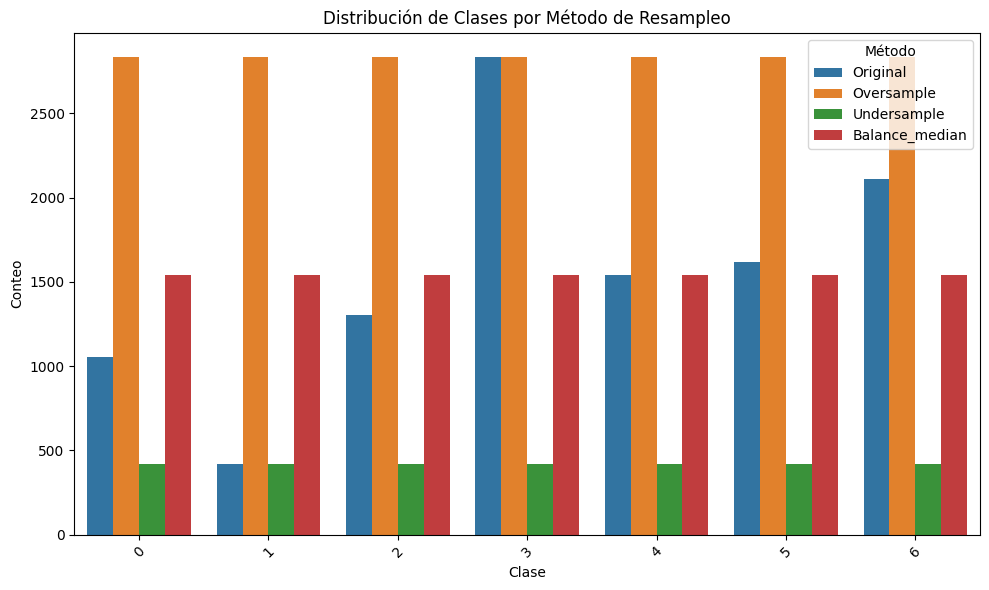

In [42]:
methods = {
    'Original': None,
    'Oversample': 'oversample',
    'Undersample': 'undersample',
    'Balance_median': 'balance_median'
}
resampled = {label: apply_resampling(X_train, y_train, m)[1] for label, m in methods.items()}

def plot_distributions(y_dict):
    df = pd.DataFrame([
        {'Clase': cls, 'Conteo': cnt, 'Método': label}
        for label, y in y_dict.items()
        for cls, cnt in Counter(y).items()
    ])
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df, x='Clase', y='Conteo', hue='Método', palette="tab10")
    plt.title('Distribución de Clases por Método de Resampleo')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_distributions(resampled)


E nla gráfica anterior se observa como varía la distribución de clases tras aplicar distintas técnicas de resampleo. En el conjunto **original**, las clases presentan un claro desequilibrio. El método **oversample** iguala todas las clases al tamaño de la clase mayoritaria, mientras que **undersample** las reduce al tamaño de la minoritaria. Por su parte, **balance_median** las iguala a un tamaño intermedio (la mediana), ofreciendo un compromiso entre pérdida de datos y sobreajuste.


#### Codificación y configuración de los modelos + balanceo

Esta sección evalúa el rendimiento de modelos clásicos de clasificación (Decision Tree, SVM, KNN) bajo distintas combinaciones de técnicas de escalado (`None`, `StandardScaler`, `RobustScaler`) y estrategias de balanceo (`None`, `oversample`, `undersample`, `balance_median`). Se utiliza `Pipeline` para integrar cada escalador con el clasificador correspondiente, garantizando un flujo limpio y sin data leakage.


In [43]:
# Modelos clásicos
model_defs = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC()
}

# Escaladores
scalers = {
    'None': None,
    'Standard': StandardScaler(),
    'Robust': RobustScaler()
}

balancing_methods = [None, 'oversample', 'undersample', 'balance_median']

#### Entrenamiento

In [44]:
results = []
combos = list(product(model_defs.items(), balancing_methods, scalers.items()))

pbar = tqdm(combos, desc="Entrenando modelos", ncols=120)
for (model_name, model), balance_method, (scaler_name, scaler) in pbar:
    pbar.set_postfix_str(f"{model_name} | {balance_method or 'None'} | {scaler_name}")

    # Aplicar resampleo
    X_r, y_r = apply_resampling(X_train, y_train, method=balance_method)

    # Construir el pipeline
    steps = [('clf', model)]
    if scaler:
        steps.insert(0, ('scaler', scaler))
    pipeline = SklearnPipeline(steps)

    # Entrenar y predecir
    pipeline.fit(X_r, y_r)
    y_pred = pipeline.predict(X_val)

    # Métricas
    acc = accuracy_score(y_val, y_pred)
    p_macro, r_macro, f_macro, _ = precision_recall_fscore_support(y_val, y_pred, average='macro', zero_division=0)

    results.append({
        'model': model_name,
        'balancing': balance_method or 'None',
        'scaler': scaler_name,
        'n_train_samples': len(y_r),
        'val_acc': acc,
        'precision_macro': p_macro,
        'recall_macro': r_macro,
        'f1_macro': f_macro,
        'y_pred': y_pred.copy()
    })

pbar.close()
df_results = pd.DataFrame(results)


Entrenando modelos: 100%|████████████████████████████████| 36/36 [00:32<00:00,  1.11it/s, SVM | balance_median | Robust]


#### Comparación de métricas por modelo y técnica de balanceo

In [45]:
metrics_df = df_results.melt(
    id_vars=['model', 'balancing', 'scaler'],
    value_vars=['val_acc', 'f1_macro'],
    var_name='metric',
    value_name='score'
)
metrics_df['metric'] = metrics_df['metric'].map({'val_acc': 'Accuracy', 'f1_macro': 'F1 macro'})


In [46]:
def plot_metric_overview(df, metric='F1 macro'):
    """
    Genera:
    1. Un catplot de modelos vs score por scaler y tipo de balanceo (hue)
    2. Un heatmap resumen por modelo y combinación (balancing | scaler)

    Parameters:
    - df: DataFrame en formato largo con columnas ['model', 'balancing', 'scaler', 'metric', 'score']
    - metric: métrica a visualizar ('F1 macro' o 'Accuracy')
    """
    # --- 1. Catplot por escalador ---
    sns.set_theme(style="whitegrid", palette="Set2")
    g = sns.catplot(
        data=df[df['metric'] == metric],
        x='model', y='score',
        hue='balancing', col='scaler',
        kind='bar',
        height=5, aspect=1.4
    )
    g.set_titles("{col_name} Scaler")
    g.set_axis_labels("Modelo", metric)
    for ax in g.axes.flat:
        ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

    # --- 2. Heatmap resumen ---
    df_plot = df[df['metric'] == metric].copy()
    df_plot['combo'] = df_plot['balancing'].astype(str) + " | " + df_plot['scaler'].astype(str)
    pivot_df = df_plot.pivot_table(index='model', columns='combo', values='score')

    plt.figure(figsize=(16, 6))
    sns.heatmap(pivot_df, annot=True, fmt='.2f', cmap='YlGnBu', cbar_kws={"shrink": 0.8})
    plt.title(f"{metric} por Modelo y Combinación (Balanceo | Scaler)", fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()


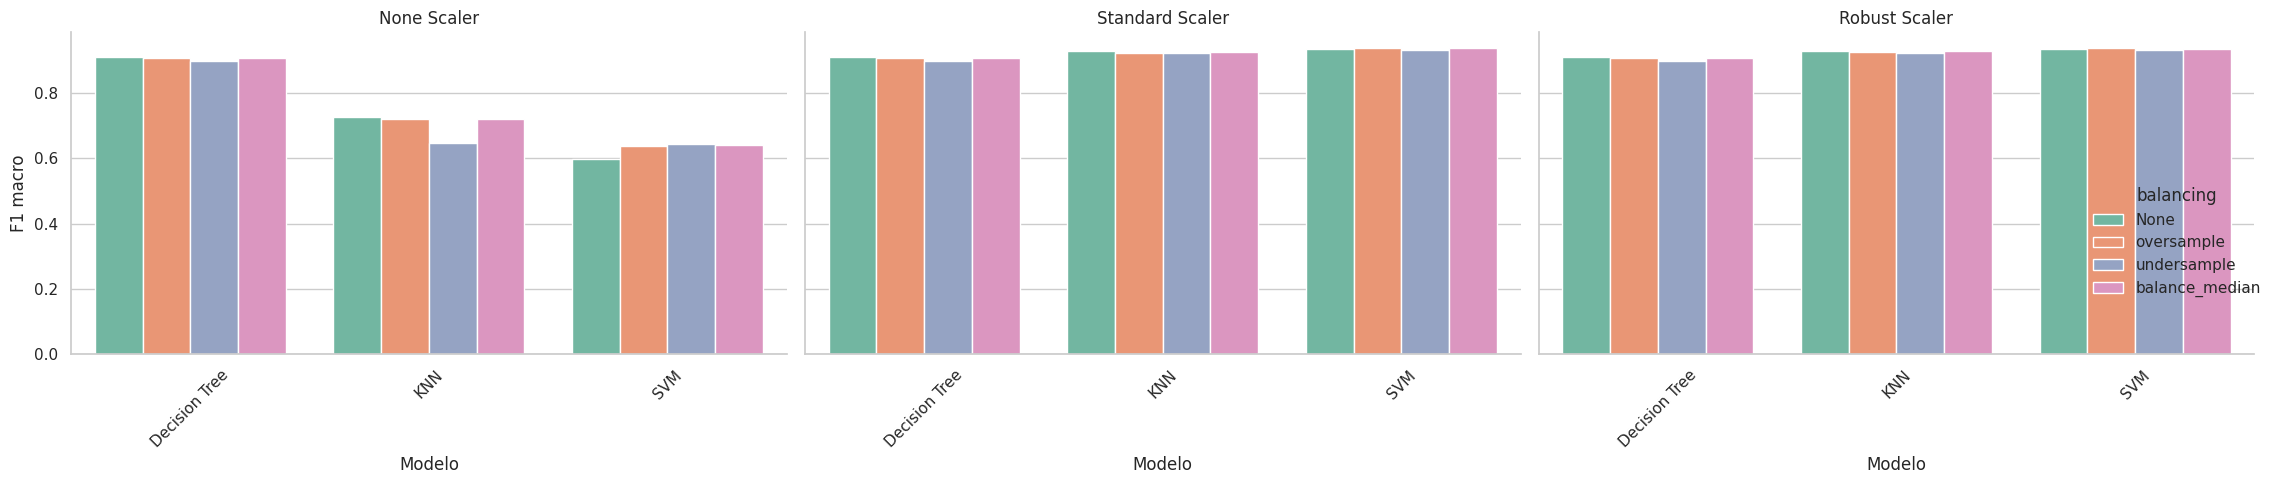

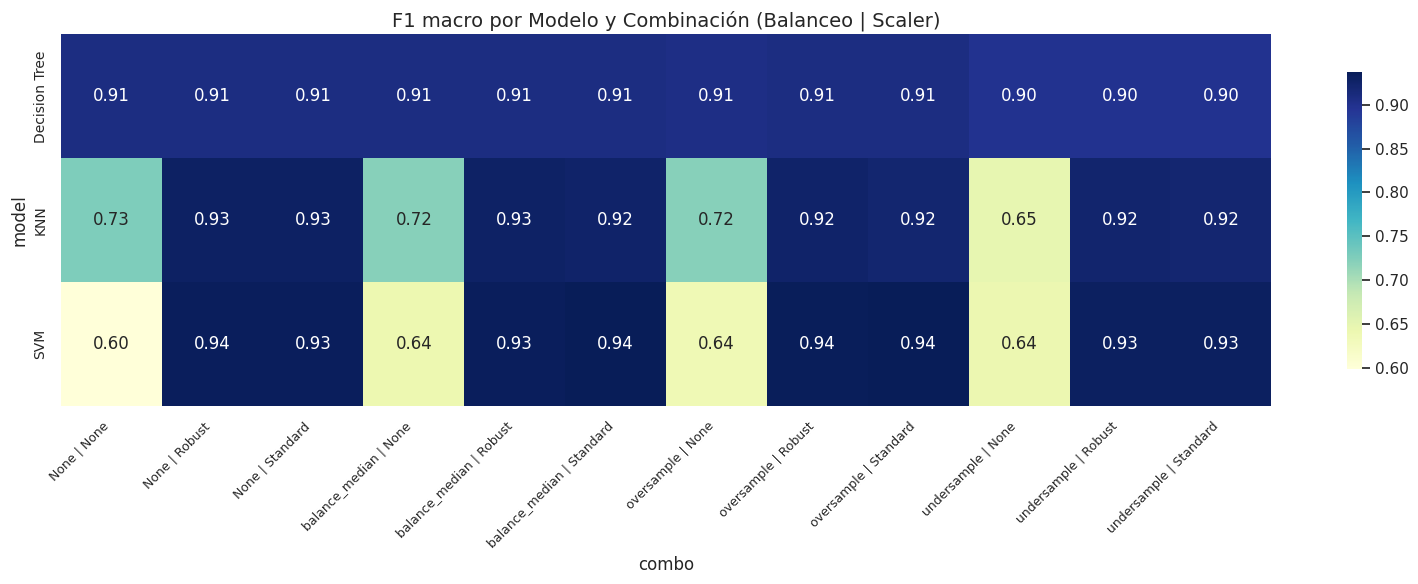

In [47]:
plot_metric_overview(metrics_df, metric='F1 macro')

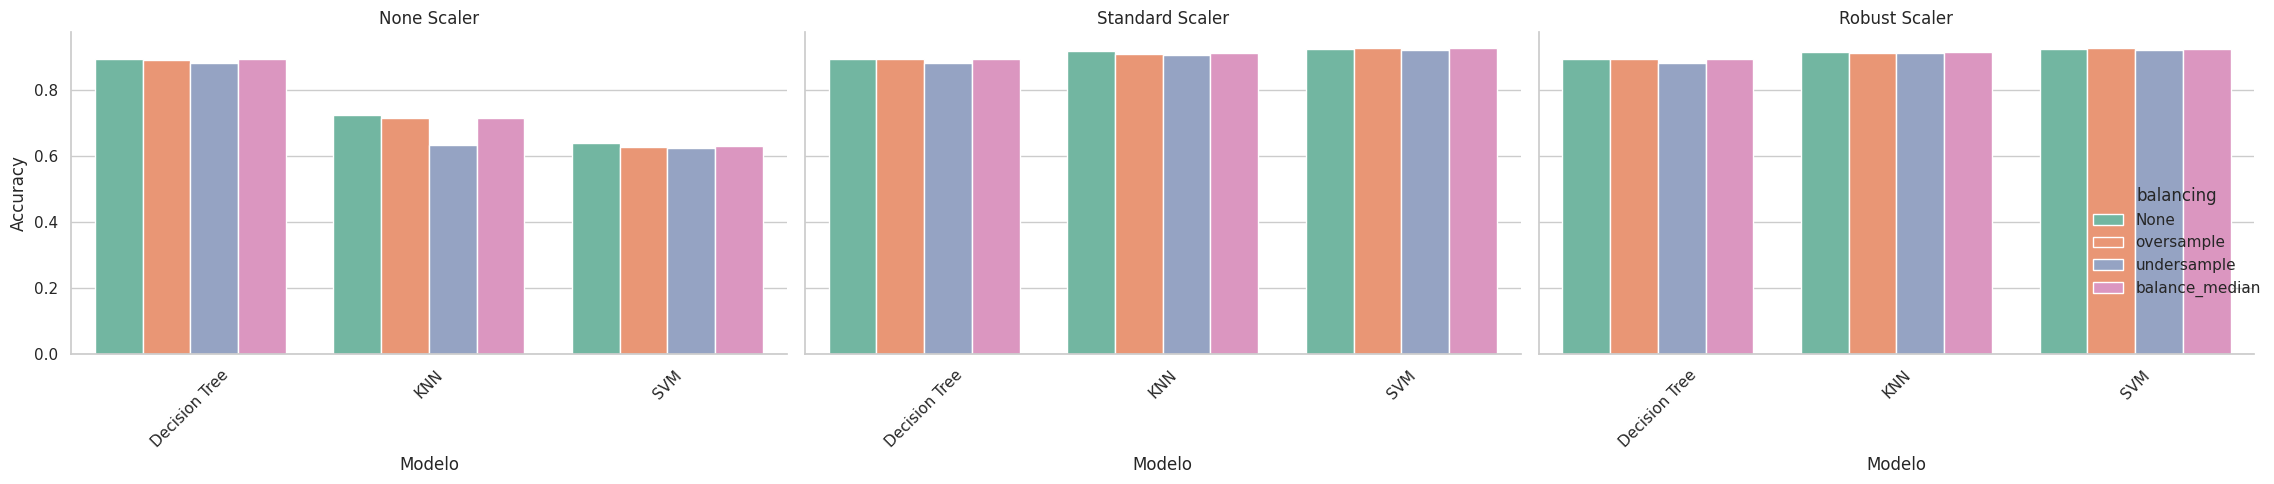

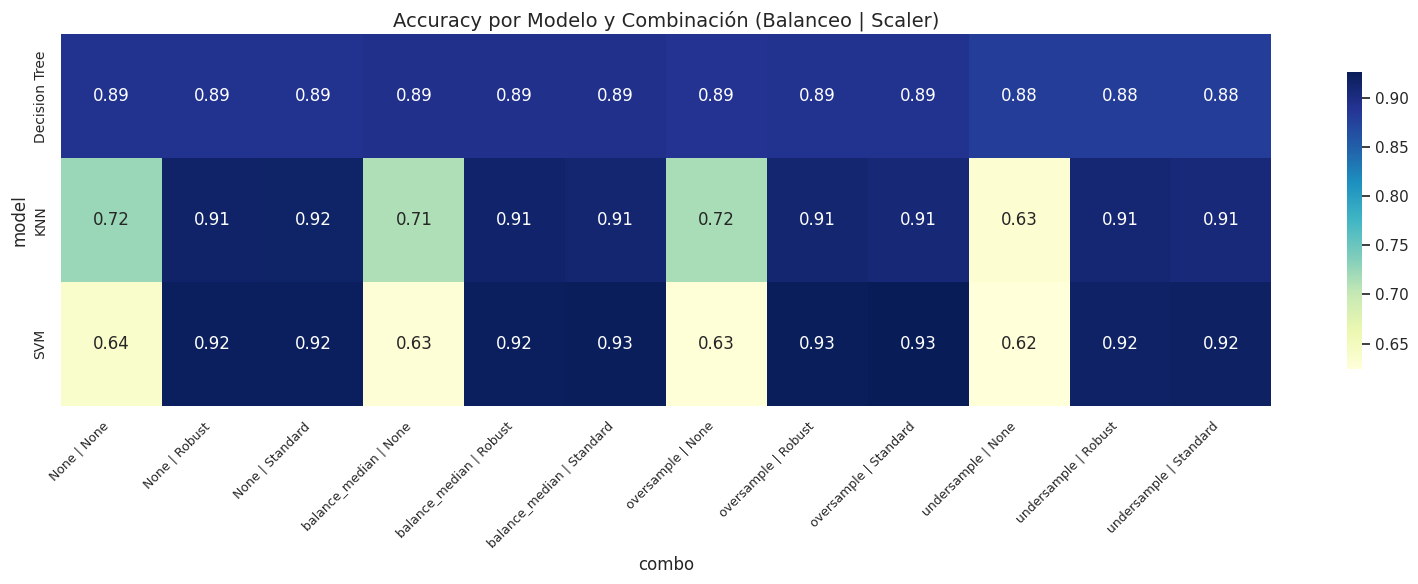

In [48]:
plot_metric_overview(metrics_df, metric='Accuracy')


Los resultados muestran una clara tendencia en ambas métricas (**Accuracy** y **F1 macro**): modelos como **KNN** y **SVM** se benefician considerablemente del uso de escalado, especialmente con `StandardScaler` o `RobustScaler`, alcanzando métricas cercanas a las del árbol de decisión. Sin escalado, su rendimiento cae significativamente, evidenciando su sensibilidad a la magnitud de las variables.

Por otro lado, el **árbol de decisión** mantiene un rendimiento alto y constante sin importar el escalador o la técnica de balanceo, lo que confirma su robustez ante este tipo de transformaciones. En general, el escalado tiene un impacto mayor que el resampleo, especialmente en modelos no basados en árboles, lo que sugiere que un buen preprocesamiento puede ser más efectivo que modificar la distribución de clases.


#### Matrices de Confusión Normalizadas de los 2 mejores y los 2 peores modelos + técnica de balanceo + técnica de escalado según f1-macro

In [49]:
def get_global_best_and_worst(df, metric='f1_macro', top_n=2):
    """
    Devuelve los top_n mejores y peores combinaciones de modelo+balanceo+scaler
    según la métrica especificada.
    """
    top = df.nlargest(top_n, metric).reset_index(drop=True)
    bottom = df.nsmallest(top_n, metric).reset_index(drop=True)
    return top, bottom

def plot_confusion_rows_from_preds(rows, y_true, labels, title, cmap):
    """
    Dibuja una fila de matrices de confusión normalizadas,
    mostrando modelo + balanceo + escalador en el título.
    """
    fig, axes = plt.subplots(1, len(rows), figsize=(6*len(rows), 5), sharey=True)
    if len(rows) == 1:
        axes = [axes]

    for ax, (_, row) in zip(axes, rows.iterrows()):
        y_pred = row['y_pred']
        cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))
        cm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
        sns.heatmap(cm, annot=True, fmt='.1%', cmap=cmap,
                    xticklabels=labels, yticklabels=labels, cbar=False,
                    ax=ax, annot_kws={'fontsize':10})
        
        # Título detallado
        ax.set_title(
            f"{row['model']}\nBalance: {row['balancing']} | Scaler: {row['scaler']}", 
            fontsize=11
        )
        ax.set_xlabel("Predicción", fontsize=10)
        ax.set_ylabel("Verdadero", fontsize=10)
        ax.tick_params(labelsize=9)

    plt.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.94])
    plt.show()
 

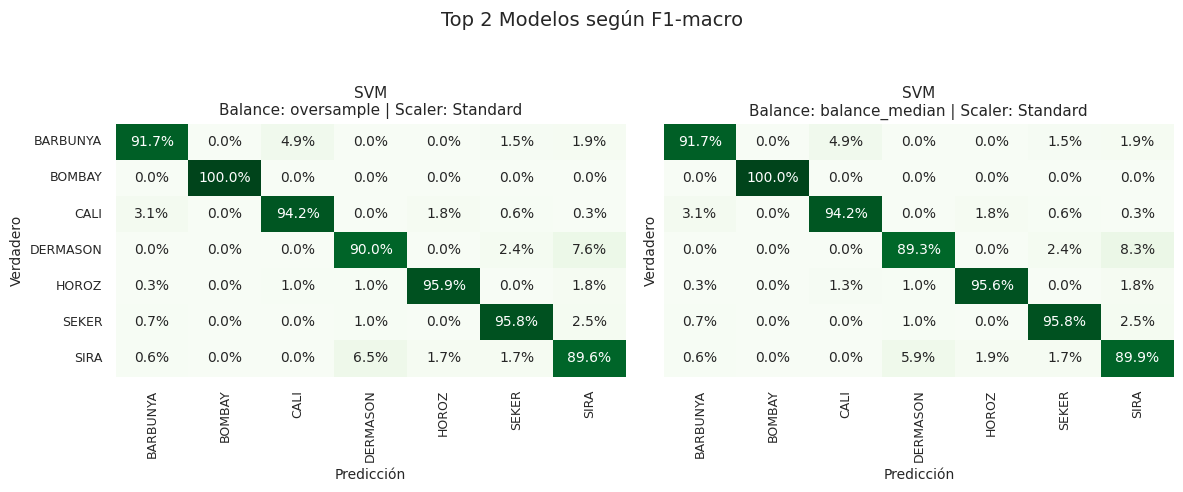

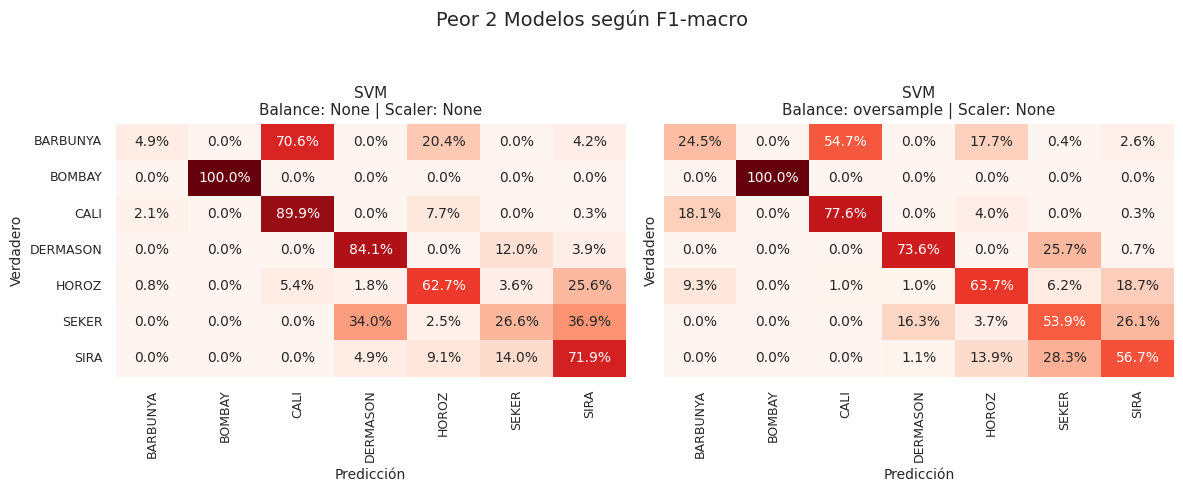

In [50]:

top2, bot2 = get_global_best_and_worst(df_results)
plot_confusion_rows_from_preds(top2, y_val, le.classes_, title="Top 2 Modelos según F1‑macro", cmap='Greens')
plot_confusion_rows_from_preds(bot2, y_val, le.classes_, title="Peor 2 Modelos según F1‑macro", cmap='Reds')


Las matrices de confusión muestran un claro contraste entre las configuraciones más efectivas y las menos eficientes según F1-macro. Los mejores modelos (ambos SVM con `StandardScaler` y técnicas de balanceo `oversample` o `balance_median`) presentan predicciones altamente precisas en todas las clases, superando el 89% de acierto en cada una de ellas. Por el contrario, los peores modelos (SVM sin escalado y con `None` o `oversample`) exhiben un rendimiento muy irregular, con aciertos bajos en varias clases y confusiones severas especialmente en clases como `BARBUNYA`, `CALI` o `SEKER`, lo que indica que el escalado y el resampleo bien aplicados son claves para una clasificación equilibrada y robusta.


# Parte 2: Ensembles y Clustering

## Ensembles: Clasificadores Basados en Conjunto

En esta sección se exploran algoritmos de ensamble, que combinan múltiples clasificadores base para obtener un rendimiento más robusto que los modelos individuales. Se incluyen métodos como Random Forest, AdaBoost, Gradient Boosting, XGBoost y CatBoost, así como tres variantes del `VotingClassifier`. Este último ensambla predicciones de distintos modelos mediante voto mayoritario (hard) o promedio de probabilidades (soft). Todos los modelos se evaluarán bajo distintas técnicas de balanceo y escalado, al igual que en la parte anterior.


### Configuración de ensembles

In [51]:
ensemble_defs = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='mlogloss'),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=0),
    
    'Voting Hard': VotingClassifier(estimators=[
        ('dt', DecisionTreeClassifier(random_state=42)),
        ('knn', KNeighborsClassifier()),
        ('svc', SVC())  # No necesita predict_proba
    ], voting='hard'),

    'Voting Soft': VotingClassifier(estimators=[
        ('dt', DecisionTreeClassifier(random_state=42)),
        ('knn', KNeighborsClassifier()),
        ('svc', SVC(probability=True))  # Esto es clave para el voting
    ], voting='soft'),

    'Voting Weighted': VotingClassifier(estimators=[
        ('dt', DecisionTreeClassifier(random_state=42)),
        ('knn', KNeighborsClassifier()),
        ('svc', SVC(probability=True))  # Esto es clave para el voting
    ], voting='soft', weights=[2, 1, 2])
}


### Entrenamiento

In [52]:
results_ens = []
combos = list(product(ensemble_defs.items(), balancing_methods, scalers.items()))
pbar = tqdm(combos, desc="Entrenando ensembles", ncols=120)

for (model_name, model), balance_method, (scaler_name, scaler) in pbar:
    pbar.set_postfix_str(f"{model_name} | {balance_method or 'None'} | {scaler_name}")

    # Resampleo
    X_r, y_r = apply_resampling(X_train, y_train, method=balance_method)

    # Escalado
    if scaler:
        pipe = SklearnPipeline([
            ('scaler', scaler),
            ('clf', model)
        ])
    else:
        pipe = SklearnPipeline([('clf', model)])

    pipe.fit(X_r, y_r)
    y_pred = pipe.predict(X_val)

    acc = accuracy_score(y_val, y_pred)
    p_macro, r_macro, f_macro, _ = precision_recall_fscore_support(
        y_val, y_pred, average='macro', zero_division=0
    )

    results_ens.append({
        'model': model_name,
        'balancing': balance_method or 'None',
        'scaler': scaler_name,
        'n_train_samples': len(y_r),
        'val_acc': acc,
        'precision_macro': p_macro,
        'recall_macro': r_macro,
        'f1_macro': f_macro,
        'y_pred': y_pred.copy()
    })

pbar.close()
df_ens = pd.DataFrame(results_ens)


Entrenando ensembles: 100%|██████████████████| 96/96 [19:36<00:00, 12.25s/it, Voting Weighted | balance_median | Robust]


### Comparación de Resultados

In [53]:
metrics_ens = df_ens.melt(
    id_vars=['model', 'balancing', 'scaler'],
    value_vars=['val_acc', 'f1_macro'],
    var_name='metric',
    value_name='score'
)
metrics_ens['metric'] = metrics_ens['metric'].map({
    'val_acc': 'Accuracy',
    'f1_macro': 'F1 macro'
})


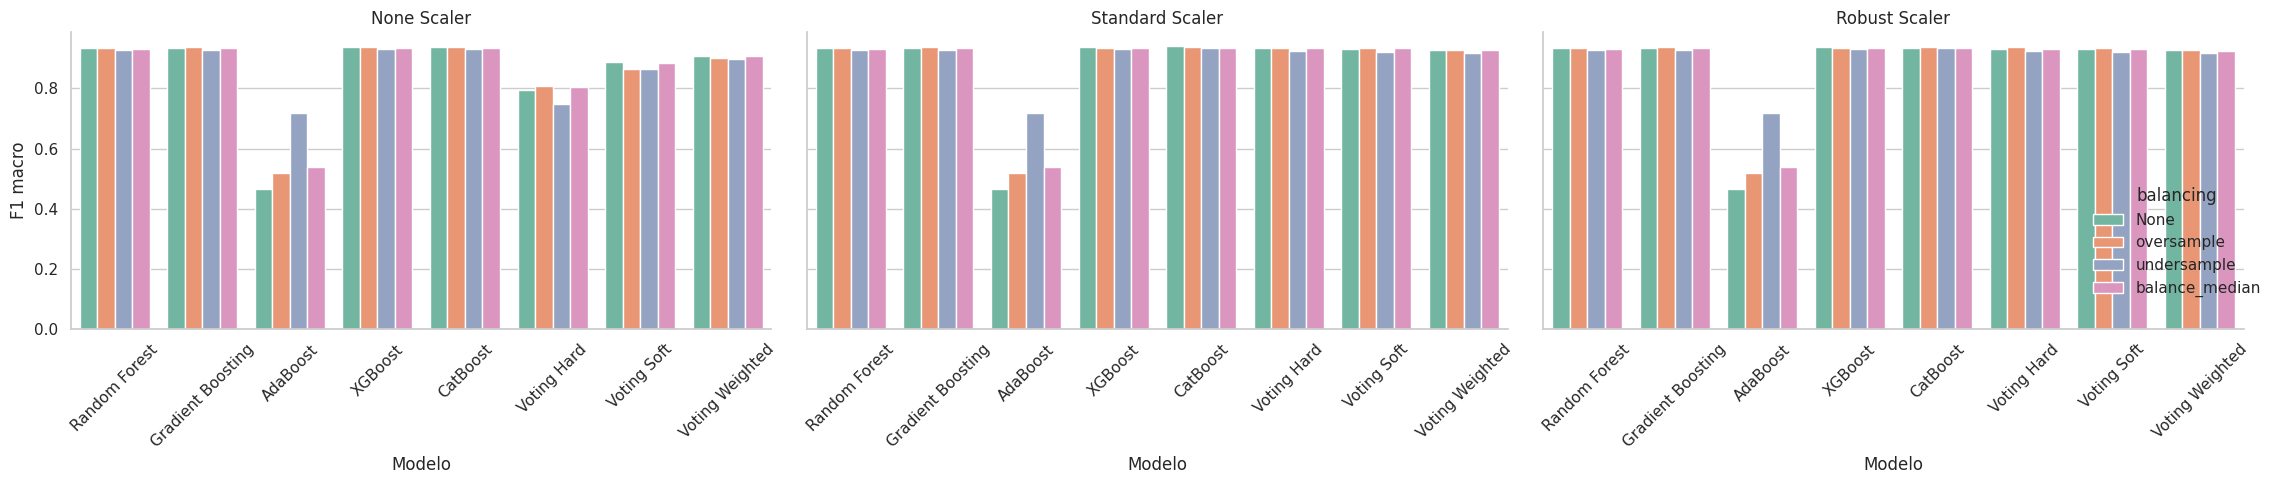

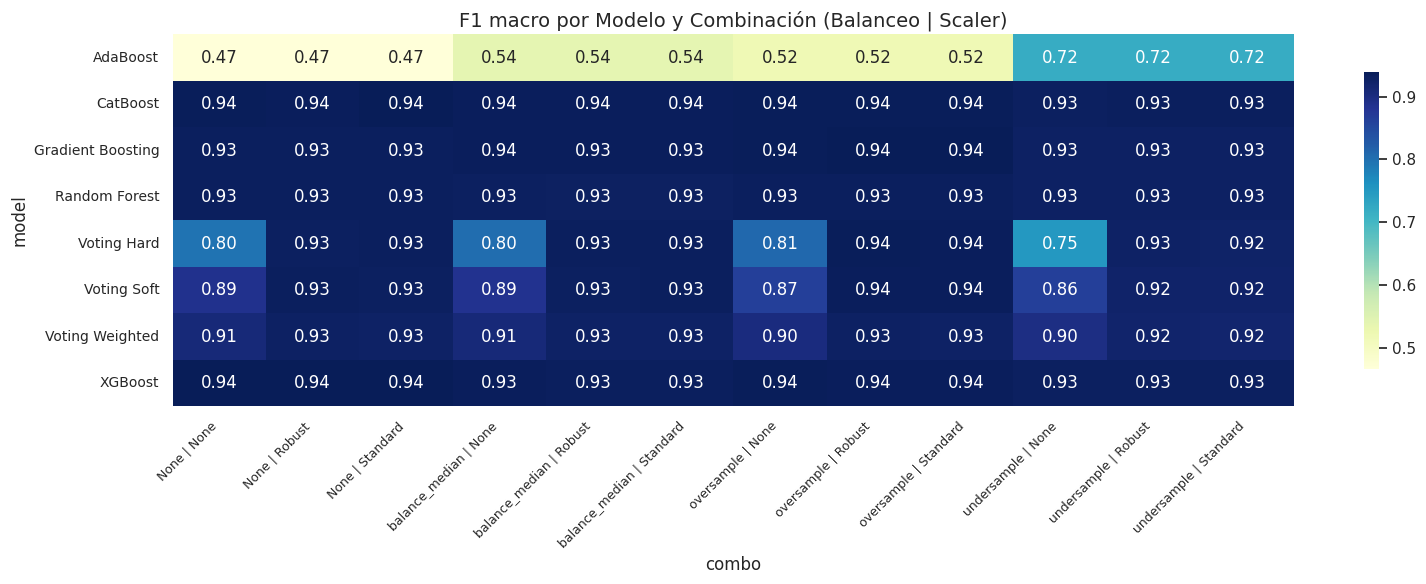

In [54]:
plot_metric_overview(metrics_ens, metric='F1 macro')


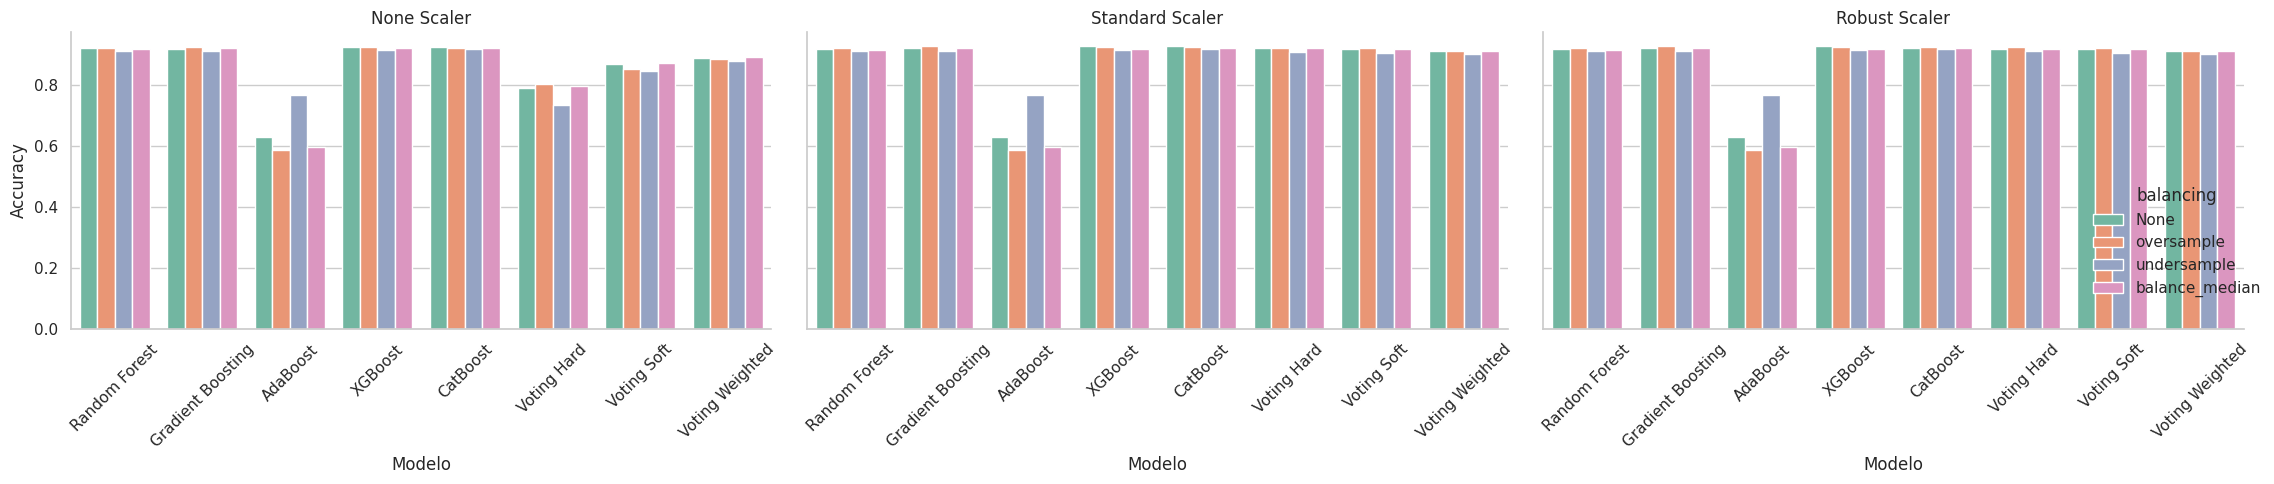

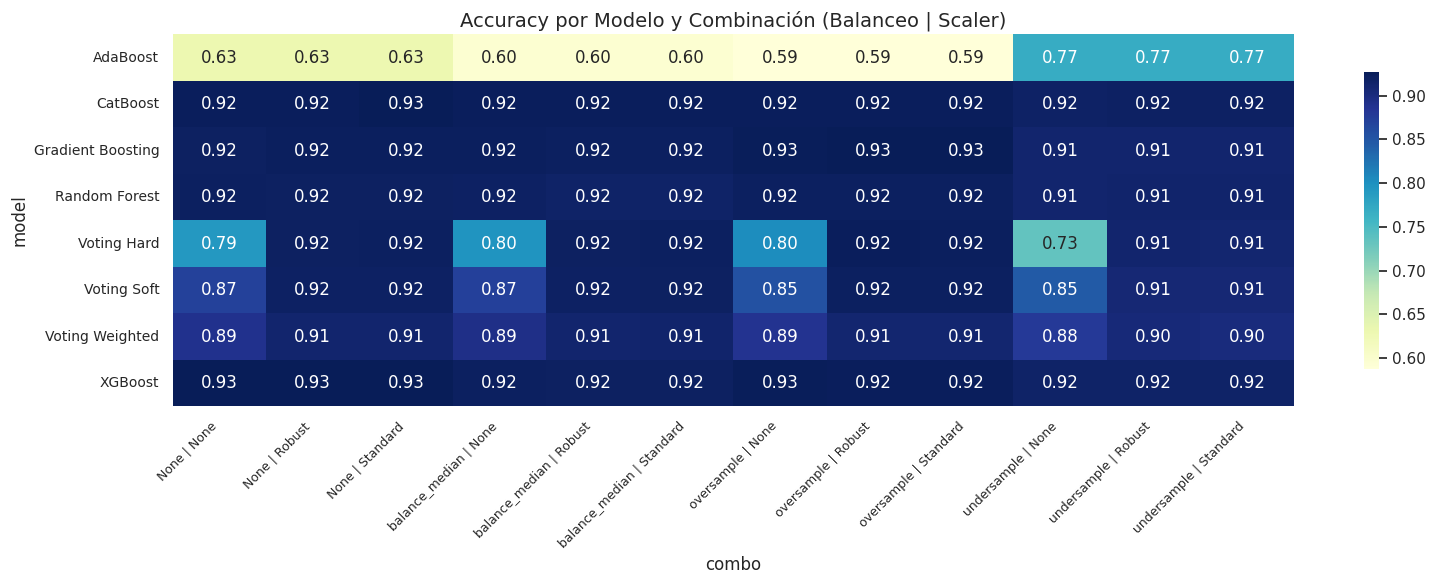

In [55]:
plot_metric_overview(metrics_ens, metric='Accuracy')

Los mapas de calor reflejan el rendimiento de los modelos de ensamblado bajo distintas combinaciones de balanceo y escalado. En términos de F1-macro, los métodos de boosting como **XGBoost**, **CatBoost** y **Gradient Boosting** muestran una estabilidad notable, superando consistentemente el 0.93 sin verse afectados por la técnica de preprocesamiento empleada. En contraste, **AdaBoost** es significativamente más sensible, con F1-macro rondando el 0.68 sin escalado, aunque mejora notablemente con técnicas como `undersample`.

En cuanto a **accuracy**, la tendencia se mantiene: los modelos de boosting ofrecen un rendimiento robusto en todas las configuraciones. **VotingClassifier** (especialmente la versión `Hard`) presenta mayor variabilidad, afectado negativamente por la ausencia de escalado o un mal balanceo, como se ve en combinaciones con `undersample`. Esto sugiere que, si bien el ensamble puede ofrecer beneficios, su efectividad depende más de un preprocesamiento adecuado que en los modelos de boosting ya optimizados.


#### Matrices de Confusión: Top y Bottom Ensembles

A continuación se muestran las matrices de confusión normalizadas correspondientes a los dos mejores y dos peores modelos de ensemble en términos de F1-macro. Estas matrices permiten evaluar visualmente el rendimiento global y por clase, destacando posibles sesgos o debilidades del modelo.


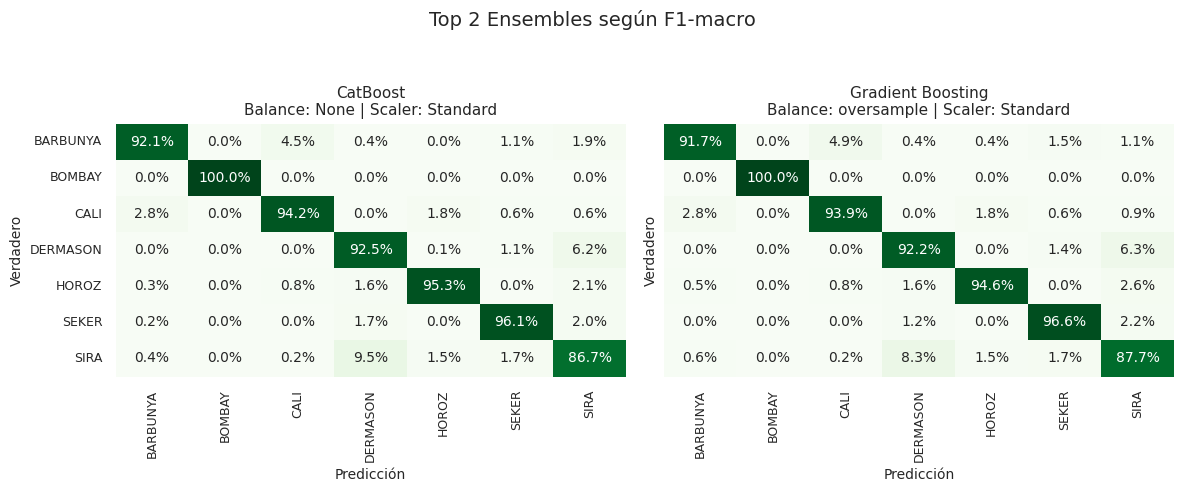

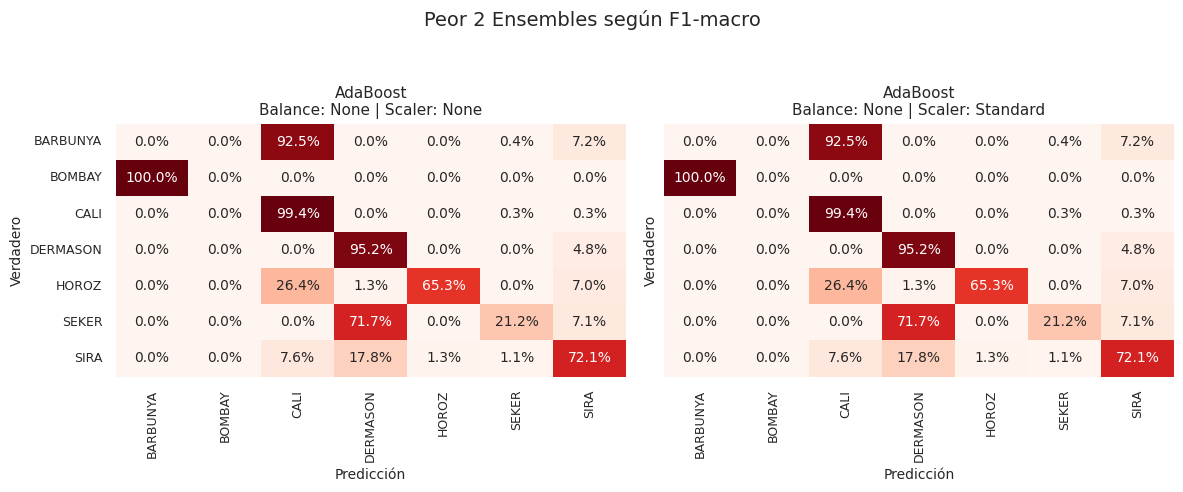

In [56]:

top_ens, bot_ens = get_global_best_and_worst(df_ens)

plot_confusion_rows_from_preds(top_ens, y_val, le.classes_, title="Top 2 Ensembles según F1‑macro", cmap='Greens')
plot_confusion_rows_from_preds(bot_ens, y_val, le.classes_, title="Peor 2 Ensembles según F1‑macro", cmap='Reds')


Las matrices de confusión confirman el excelente rendimiento de los mejores modelos de ensamble, como **CatBoost** y **Gradient Boosting**, especialmente cuando se usa escalado estándar. Ambos clasificadores muestran una capacidad elevada para distinguir entre clases, con valores superiores al 90% en la mayoría de etiquetas, destacando la estabilidad y precisión en clases como BOMBAY, CALI o SEKER.

En contraste, **AdaBoost** se posiciona como el peor modelo ensamble, incluso tras aplicar escalado. Su rendimiento es especialmente deficiente en clases como BARBUNYA y SIRA, con altas tasas de confusión. Este comportamiento evidencia que AdaBoost, aunque simple y rápido, no logra adaptarse bien a datasets multiclase complejos como este, y su rendimiento no mejora significativamente con técnicas de preprocesamiento básicas.


### Comparativa Ensembles vs Modelos Individuales

Al comparar los **modelos individuales clásicos** con los **algoritmos de ensamble**, se observa una mejora significativa y consistente en las métricas de rendimiento (F1-macro y Accuracy) cuando se utilizan modelos basados en conjunto.

Por ejemplo, **SVM** en solitario requiere un escalado previo para rendir correctamente, y aun así sus resultados son sensibles al método de balanceo utilizado. Sin embargo, al integrarlo dentro de un `VotingClassifier` (como en la versión **Soft** o **Weighted**), el rendimiento mejora notablemente gracias a la combinación de decisiones con KNN y Decision Tree, amortiguando sus debilidades individuales.

Del mismo modo, comparando **Decision Tree** frente a **Random Forest** o **Gradient Boosting**, se confirma la ventaja del aprendizaje en conjunto: los árboles individuales son propensos al sobreajuste y su rendimiento depende mucho del preprocesamiento, mientras que sus versiones en ensemble alcanzan valores cercanos al 94% de F1-macro de forma robusta, incluso sin necesidad de balanceo ni escalado sofisticado.

En resumen, los métodos de ensemble no solo superan a sus equivalentes individuales, sino que también se muestran más **estables frente a cambios en los datos** (como resampleo o escalado), lo que los convierte en una opción preferente para tareas de clasificación multiclase complejas como esta.


## Clustering: Agrupamiento no supervisado

A continuación, se analiza la estructura del dataset sin utilizar labels, mediante clustering. Se emplean algoritmos de clustering populares para identificar patrones y agrupar observaciones similares, como vimos en la sección de visualización con el pairplot. A diferencia de la clasificación, el clustering es una tarea no supervisada, por lo que las evaluaciones se basan en métricas internas como el Silhouette Score o el Davies-Bouldin Index.

#### Algoritmos de clustering y escaladores

Para el análisis de agrupamiento no supervisado se han seleccionado cuatro algoritmos representativos y ampliamente utilizados: **KMeans**, **Agglomerative Clustering**, **Gaussian Mixture Models (GMM)** y **DBSCAN**. Todos ellos permiten explorar estructuras internas en los datos sin necesidad de etiquetas.

Dado que el dataset original contiene **7 clases conocidas**, se ha fijado `n_clusters=7` en los métodos que lo requieren. Esto permite evaluar si los algoritmos son capaces de recuperar una estructura similar. En el caso de **DBSCAN**, que no necesita definir un número de clústeres, se han configurado los parámetros `eps=1.5` y `min_samples=5` como punto de partida razonable para detectar agrupaciones basadas en densidad. Los valores elegidos están pensados para ser compatibles con datos escalados y evitar tanto la sobrefragmentación como la generación de un único clúster.


In [57]:

clustering_defs = {
    'KMeans': KMeans(n_clusters=7, random_state=42),
    'Agglomerative': AgglomerativeClustering(n_clusters=7, linkage='ward'),
    'GaussianMixture': GaussianMixture(n_components=7, covariance_type='full', random_state=42),
    'DBSCAN': DBSCAN(eps=1.5, min_samples=5)  # No requiere n_clusters
}


#### Entrenamiento y evaluación


Al tratarse de una tarea no supervisada, no es posible usar métricas como `accuracy`. Por ello, se emplean dos métricas **internas** para evaluar la calidad de los clústeres:

- **Silhouette Score**: mide qué tan similar es cada punto a su propio clúster frente a otros. Su valor oscila entre -1 y 1. Cuanto más cercano a 1, mejor definida está la agrupación.
- **Davies-Bouldin Index**: evalúa la compacidad y separación de los clústeres. Cuanto menor, mejor.

In [58]:
results_clust = []

# Generamos todas las combinaciones
combos = list(product(clustering_defs.items(), scalers.items(), balancing_methods))

# Bucle principal
pbar = tqdm(combos, desc="Aplicando clustering", ncols=120)
for (model_name, model), (scaler_name, scaler), balance_method in pbar:
    pbar.set_postfix_str(f"{model_name} | {balance_method or 'None'} | {scaler_name}")
    
    # 1. Balanceo del conjunto de datos
    try:
        X_r, _ = apply_resampling(X_train, y_train, method=balance_method)
    except:
        # Si el balanceo falla, se omite la combinación
        continue

    # 2. Escalado
    if scaler:
        pipeline = SklearnPipeline([
            ('scaler', scaler),
            ('clust', model)
        ])
    else:
        pipeline = SklearnPipeline([('clust', model)])

    try:
        # 3. Clustering
        preds = pipeline.fit_predict(X_r)

        n_clusters = len(np.unique(preds))
        if n_clusters < 2 or (model_name == 'DBSCAN' and len(set(preds)) == 1):
            sil, db = np.nan, np.nan
        else:
            sil = silhouette_score(X_r, preds)
            db = davies_bouldin_score(X_r, preds)

        # 4. Guardar resultados
        results_clust.append({
            'model': model_name,
            'scaler': scaler_name,
            'balancing': balance_method or 'None',
            'n_clusters': n_clusters,
            'silhouette': sil,
            'davies_bouldin': db
        })

    except Exception as e:
        # Si falla la combinación, se registra el error
        results_clust.append({
            'model': model_name,
            'scaler': scaler_name,
            'balancing': balance_method or 'None',
            'n_clusters': 0,
            'silhouette': np.nan,
            'davies_bouldin': np.nan,
            'error': str(e)
        })

pbar.close()

# DataFrame final con resultados
df_clust = pd.DataFrame(results_clust)


Aplicando clustering: 100%|███████████████████████████| 48/48 [03:22<00:00,  4.22s/it, DBSCAN | balance_median | Robust]


#### Comparación de métricas por modelo y técnica de balanceo

In [59]:
metrics_clust = df_clust.melt(
    id_vars=['model', 'scaler', "balancing"],
    value_vars=['silhouette', 'davies_bouldin'],
    var_name='metric',
    value_name='score'
)

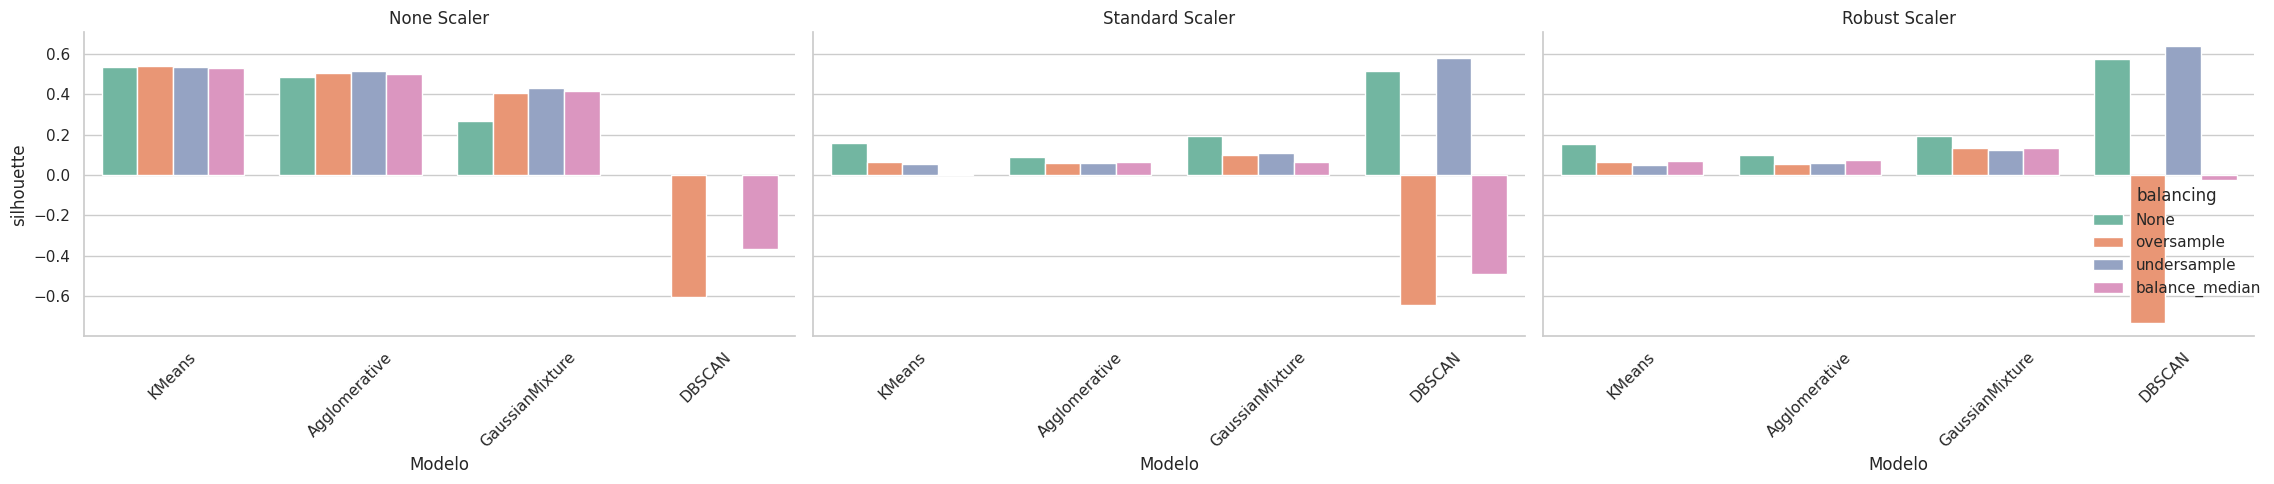

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


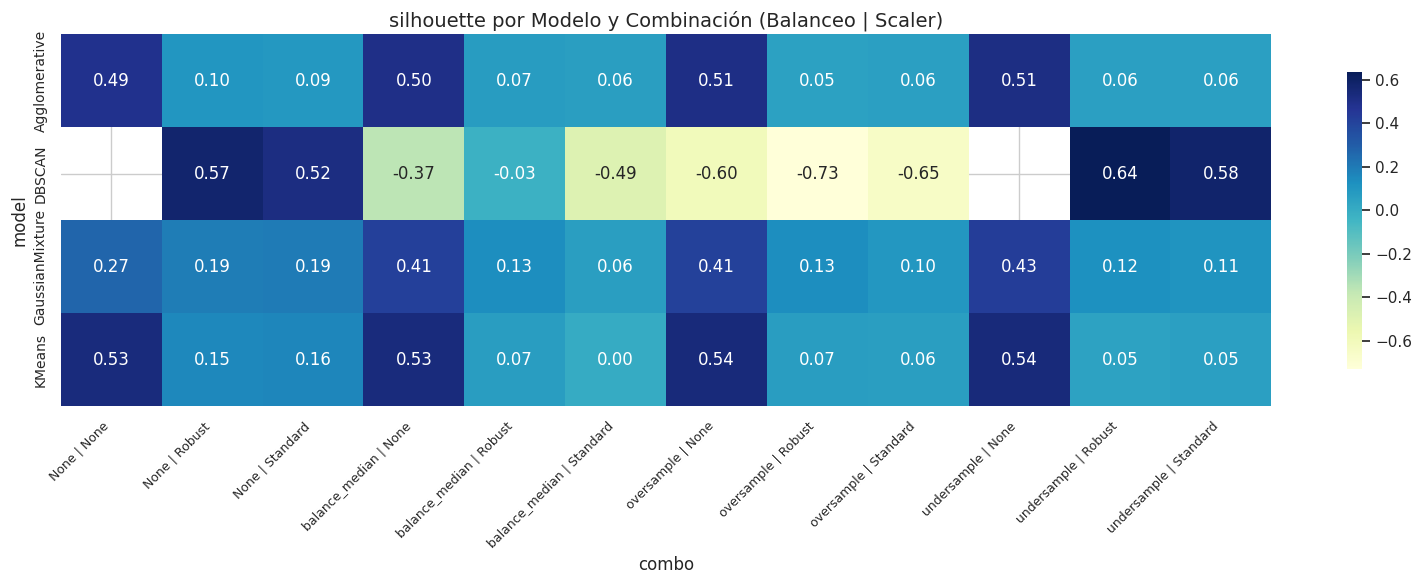

In [60]:
plot_metric_overview(metrics_clust, metric='silhouette')


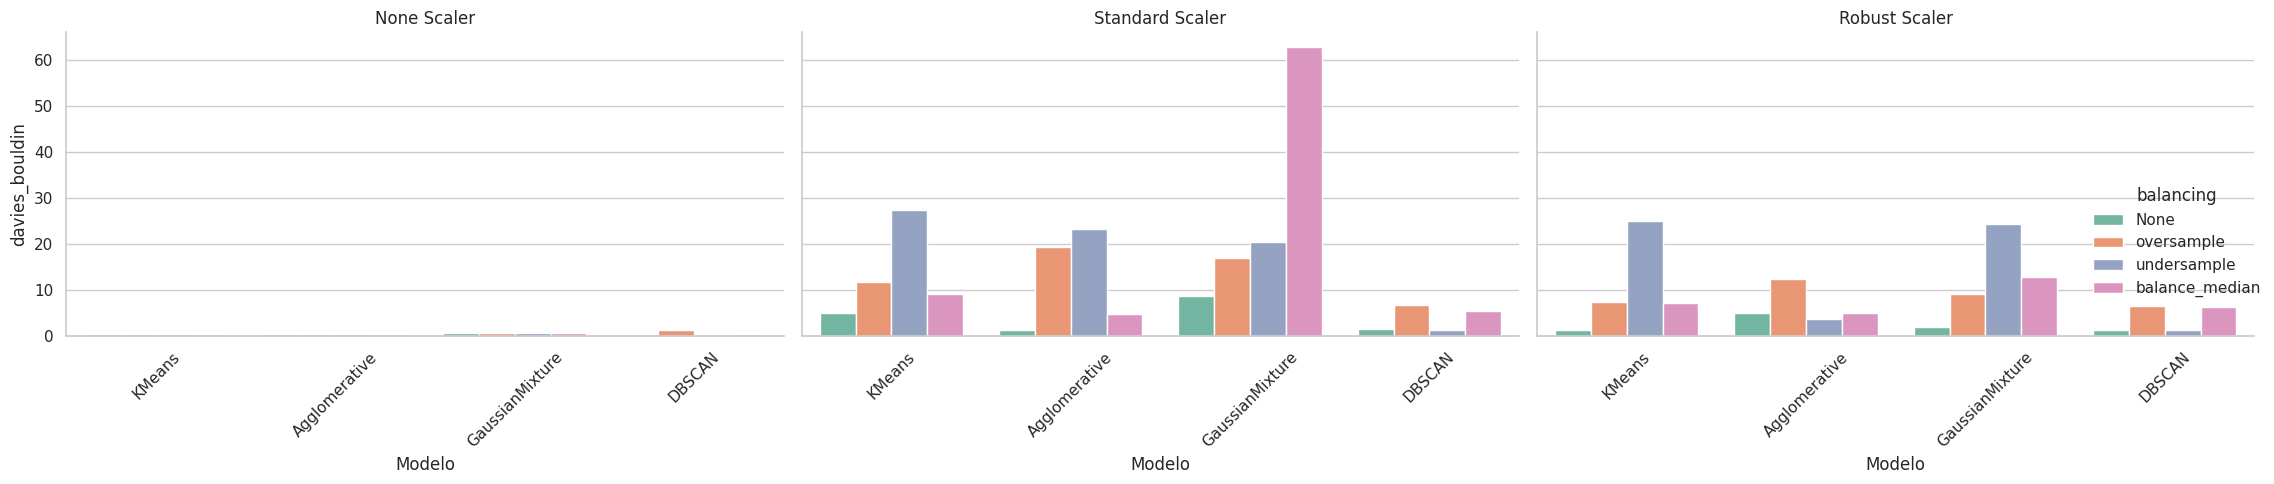

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


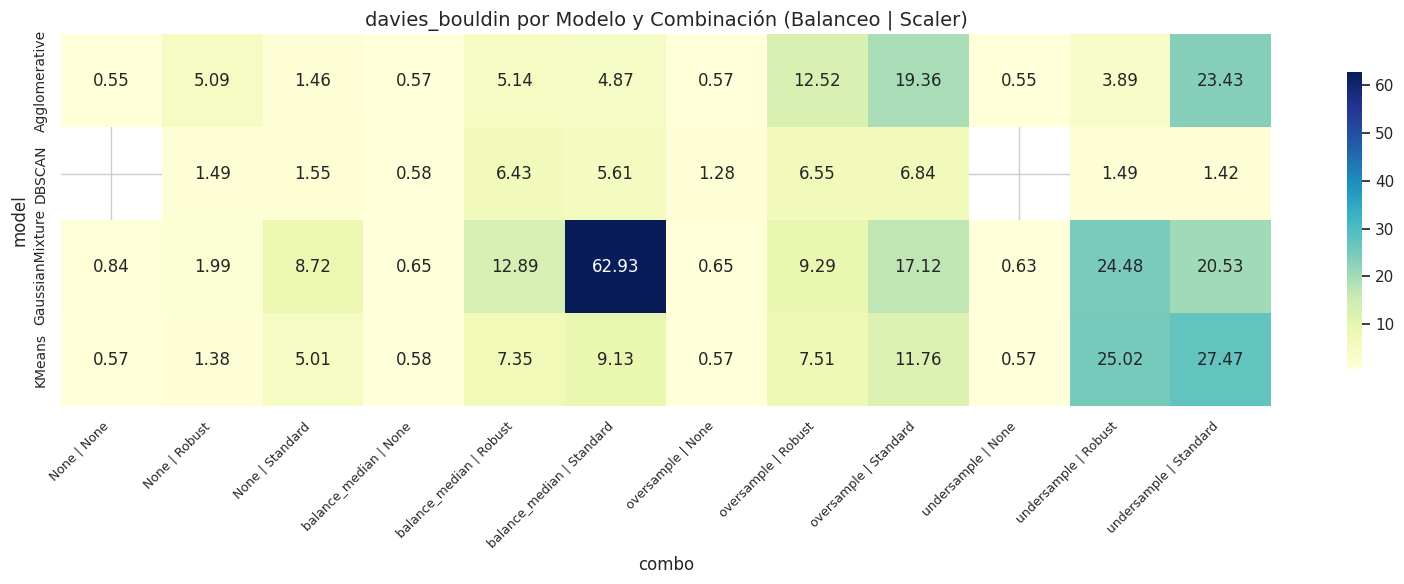

In [61]:
plot_metric_overview(metrics_clust, metric='davies_bouldin')


Se ha generado un mapa de calor que muestra los valores de *Silhouette* para cada modelo bajo distintas combinaciones de escalado y resampleo.

Se observa que **DBSCAN** y **KMeans** obtienen los mejores valores de Silhouette bajo configuraciones específicas, como `undersample + Robust` o `oversample + None`. Algunas combinaciones presentan valores negativos o cercanos a cero, lo que indica una pobre definición de clústeres.


#### Visualización PCA (2D) de las mejores configuraciones

Para facilitar la interpretación visual, se ha aplicado **PCA (Análisis de Componentes Principales)** para proyectar los datos a 2 dimensiones. Esto se ha hecho teniendo en cuenta que en este dataset, si usamos 2 componentes principales, mantenemos el >99.99% de la varianza explicada.

A continuación se visualizan los resultados de clustering utilizando la **mejor configuración para cada modelo**, según su `Silhouette Score` y `davies_bouldin` .

Cada subgráfico muestra el resultado de un modelo diferente. 


In [62]:

def plot_best_clustering_by_metric(df_clust, metric, X, y_enc, clustering_defs, scalers, n_components=2):
    """
    Visualiza la mejor configuración de clustering por modelo según una métrica interna.
    
    Args:
        df_clust: DataFrame con resultados de clustering.
        metric: Métrica a optimizar ('silhouette' o 'davies_bouldin').
        X: Datos originales.
        y_enc: Etiquetas codificadas, necesarias para el balanceo.
        clustering_defs: Diccionario con los modelos de clustering.
        scalers: Diccionario con los escaladores.
        n_components: Número de componentes para la reducción PCA (default: 2).
    """
    assert metric in ['silhouette', 'davies_bouldin'], "Métrica no válida."

    # PCA global
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    # Selección de la mejor combinación por modelo
    ascending = False if metric == 'silhouette' else True
    top_combos = df_clust.dropna().sort_values(by=metric, ascending=ascending).groupby('model').first().reset_index()

    fig = plt.figure(figsize=(14, 11))
    gs = gridspec.GridSpec(3, 2, height_ratios=[1.2, 1, 0.05])
    axes = [fig.add_subplot(gs[i, j]) for i in range(2) for j in range(2)]

    scatters = []

    for i, row in enumerate(top_combos.itertuples()):
        model_name = row.model
        scaler_name = row.scaler
        balance_method = row.balancing

        model = clustering_defs[model_name]
        scaler = scalers[scaler_name]

        X_r, _ = apply_resampling(X, y_enc, method=balance_method)
        X_pca_r = pca.fit_transform(X_r)

        # Pipeline
        if scaler:
            pipe = SklearnPipeline([
                ('scaler', scaler),
                ('clust', model)
            ])
        else:
            pipe = SklearnPipeline([('clust', model)])

        try:
            preds = pipe.fit_predict(X_r)
            
            # Máscara para -1
            mask_outliers = preds == -1
            mask_clusters = ~mask_outliers

            # Plot clusters normales
            scatter = axes[i].scatter(
                X_pca_r[mask_clusters, 0], X_pca_r[mask_clusters, 1],
                c=preds[mask_clusters], cmap='viridis', edgecolor='k', s=35
            )

            # Plot -1 en gris con leyenda
            if mask_outliers.any():
                axes[i].scatter(
                    X_pca_r[mask_outliers, 0], X_pca_r[mask_outliers, 1],
                    color='red', edgecolor='k', s=35, label='Outliers (-1)'
                )
                axes[i].legend(loc='upper right', fontsize=8)

            scatters.append(scatter)
            axes[i].set_title(
                rf"$\bf{{{model_name}}}$" + f"\nScaler: {scaler_name}, Balanceo: {balance_method}",
                fontsize=11
            )
            axes[i].set_xlabel("PCA 1")
            axes[i].set_ylabel("PCA 2")
        except Exception as e:
            axes[i].text(0.5, 0.5, f"Error: {str(e)}", ha='center')

    # Colorbar basada en el último scatter de clusters (sin incluir -1)
    cbar_ax = fig.add_subplot(gs[2, :])
    fig.colorbar(scatters[-1], cax=cbar_ax, orientation='horizontal', label='Etiqueta del clúster')

    fig.suptitle(
        f"Clustering (PCA {n_components}D) con la mejor configuración por modelo según {metric.capitalize()}",
        fontsize=16
    )
    plt.subplots_adjust(hspace=0.5)
    plt.show()

    print(f"Varianza explicada por los {n_components} componentes principales: {round(sum(pca.explained_variance_ratio_), 10) * 100}%")


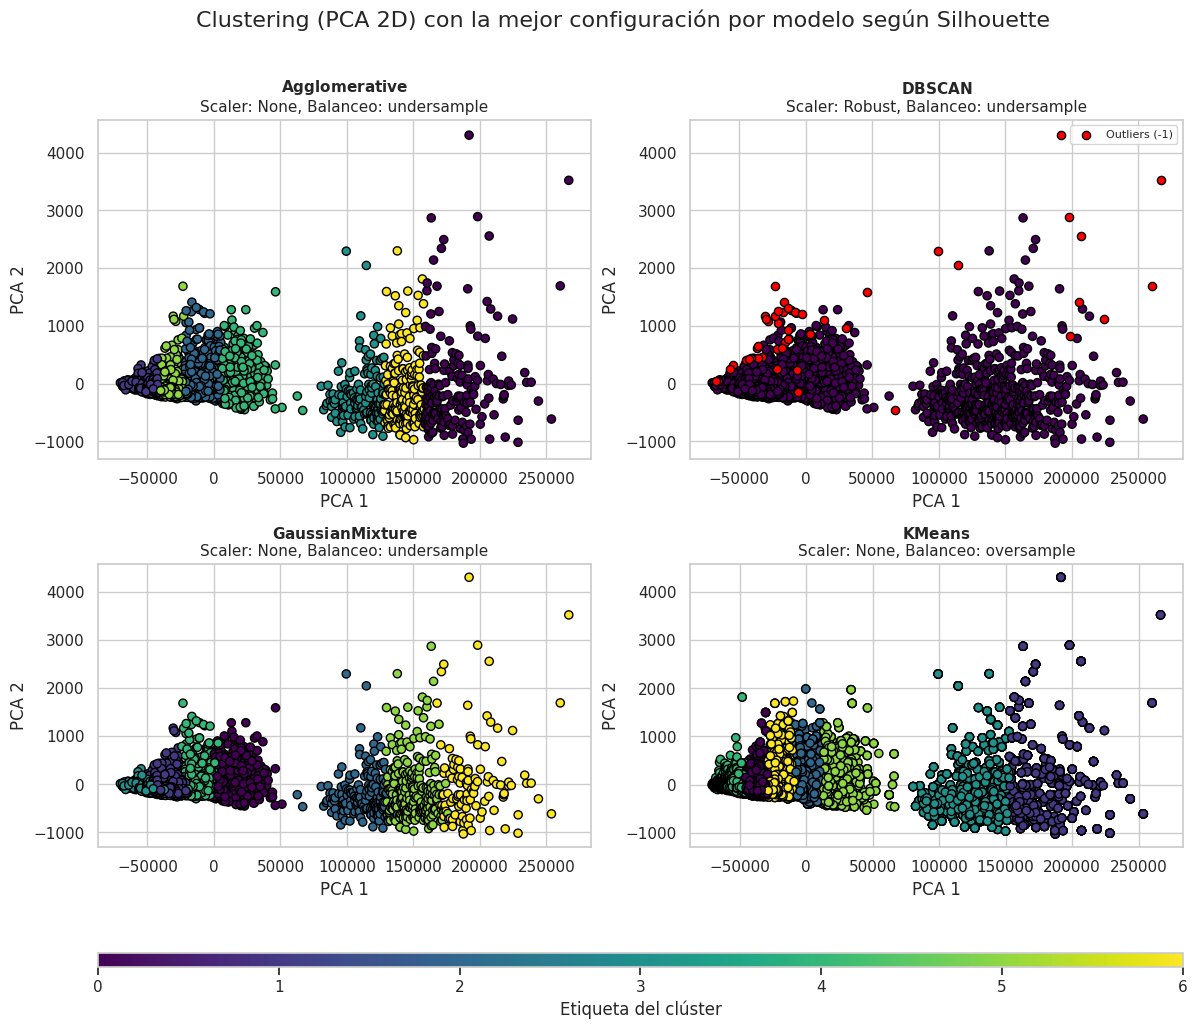

Varianza explicada por los 2 componentes principales: 99.99989248%


In [63]:
plot_best_clustering_by_metric(
    df_clust, metric='silhouette',
    X=X, y_enc=y_enc,
    clustering_defs=clustering_defs,
    scalers=scalers
)

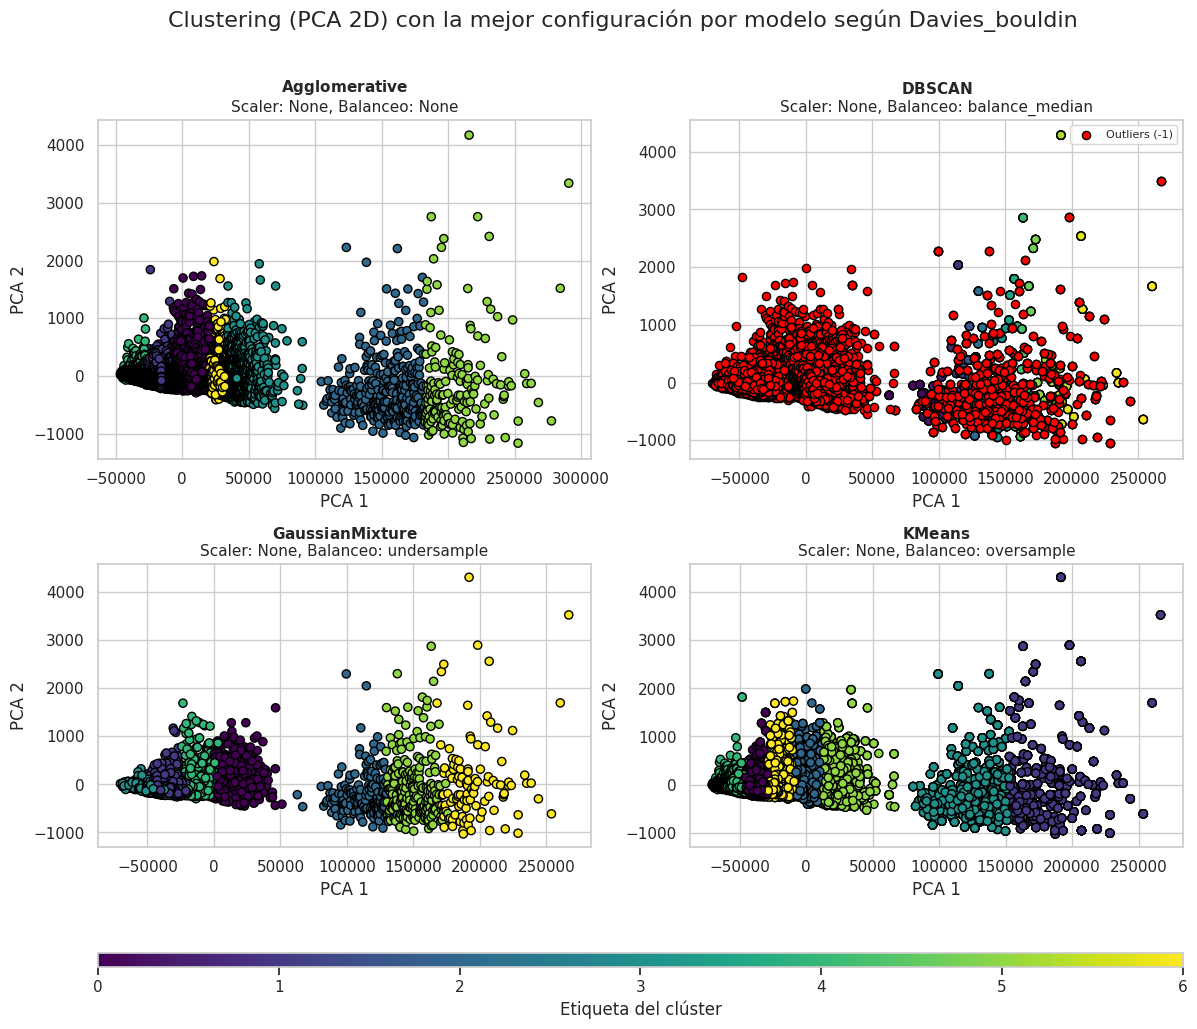

Varianza explicada por los 2 componentes principales: 99.99989248%


In [64]:
plot_best_clustering_by_metric(
    df_clust, metric='davies_bouldin',
    X=X, y_enc=y_enc,
    clustering_defs=clustering_defs,
    scalers=scalers
)

Las figuras anteriores muestran la distribución de los datos proyectados del dataset en dos dimensiones mediante **PCA**, junto con la asignación de clústeres generada por los cuatro modelos de clustering (KMeans, Agglomerative, DBSCAN y Gaussian Mixture). Para cada modelo, se ha seleccionado automáticamente la mejor combinación de escalado y balanceo según las métricas internas **Silhouette Score** y **Davies-Bouldin Index**.

La primer figura, optimizada según el **Silhouette Score**, muestra agrupamientos generalmente más compactos y separados, especialmente en el caso de **KMeans**, que consigue una segmentación más clara. **DBSCAN**, en cambio, produce agrupaciones más conservadoras, aislando menos puntos como ruido.

En la segunda figura, basada en la métrica **Davies-Bouldin** (donde valores más bajos son mejores), observamos que **KMeans** y **Gaussian Mixture** generan particiones bastante definidas, mientras que **DBSCAN** tiende a formar un gran clúster principal con algunos puntos marcados como outliers (valor -1). **Agglomerative** ofrece agrupamientos razonables, aunque con algunas regiones menos compactas. La comparación entre ambas métricas evidencia que la métrica Silhouette tiende a favorecer agrupamientos más balanceados y separados visualmente, mientras que Davies-Bouldin prioriza la compacidad interna frente a la separación entre clústeres.

# Conclusiones Finales


En la primera parte del trabajo se abordaron dos tareas clásicas del aprendizaje supervisado. En la regresión, utilizando el dataset de `students_performance`, se predijo el rendimiento académico de los alumnos aplicando una cuidadosa limpieza de datos, codificación de variables categóricas y escalado. La eliminación de columnas irrelevantes y la conservación de variables explicativas clave mejoraron la eficiencia del modelo. Modelos como CatBoost y XGBoost obtuvieron los mejores resultados, con valores R² cercanos a 0.90. Además, se implementaron varias técnicas de escalado: standard y robust, pero no hubo diferencias significativas en los resultados.

En la clasificación con el dataset de `Dry Beans`, se garantizó una división estratificada para evitar sesgos de clase y se aplicaron diferentes técnicas de resampleo y de escalado para abordar el desbalance de clases. Esto permitió que modelos como SVM y Decision Tree mejoraran sustancialmente su rendimiento, especialmente las técnicas de balanceo en métricas como F1-macro.


En la segunda parte, se introdujeron modelos de Ensembles que demostraron una mayor capacidad de generalización y estabilidad frente a distintas configuraciones. Métodos como Random Forest, Gradient Boosting, XGBoost y CatBoost superaron consistentemente a los modelos individuales en términos de accuracy y F1-macro. La implementación del VotingClassifier en sus variantes hard, soft y weighted permitió integrar múltiples clasificadores base y analizar sinergias. Mientras que modelos como XGBoost o CatBoost se mostraron robustos frente al balanceo o el escalado, AdaBoost fue más sensible a la configuración de entrada y mostró un rendimiento inferior, especialmente en clases minoritarias.


En el análisis no supervisado se emplearon varios algoritmos de clustering para descubrir patrones en los datos sin utilizar las etiquetas de clase. Se aplicaron escaladores y técnicas de resampleo de manera sistemática y se evaluó cada combinación mediante métricas internas como Silhouette Score y Davies-Bouldin Index. KMeans y Gaussian Mixture destacaron al formar clústeres bien definidos y separados, particularmente tras aplicar escalado robusto y oversampling. La visualización con PCA reveló estructuras coherentes en el espacio reducido, con una varianza explicada superior al 99%, lo que garantiza que la mayoría de la información se conserva tras la reducción dimensional. DBSCAN y Agglomerative mostraron agrupamientos más dispersos o dependientes de los parámetros, lo que los hizo más sensibles a la configuración del preprocesamiento.


En conclusión, el desarrollo completo de este trabajo ha demostrado cómo una planificación estructurada, el uso de múltiples enfoques de modelado y un preprocesamiento riguroso pueden influir decisivamente en el rendimiento final. La comparación entre modelos individuales y de conjunto mostró la superioridad general de los ensembles, tanto en estabilidad como en precisión. En el caso del clustering, la combinación de técnicas de balanceo y escalado mejoró la capacidad de los algoritmos para reflejar patrones internos. En conjunto, este análisis ha permitido no solo evaluar el rendimiento técnico de los modelos, sino también reflexionar sobre la importancia de mitigar sesgos, validar resultados con múltiples métricas y visualizar correctamente las estructuras que subyacen en los datos.
